

This Python code outlines an experiment to explore how dropout and feature sparsity affect the learning behavior and representational power of a neural network model. The experiment is conducted in four parts:

Sparsity-Dropout Grid: A grid of models is created with varying levels of feature sparsity and dropout rates. Each model is trained, and their weight matrices are visualized.

Feature Probability vs Dropout Rate: A plot is created to visualize the relationship between feature probability and dropout rate. The Frobenius norm of the weight matrix is used to measure feature representation in the model.

Integer Fractions: This part of the experiment investigates the impact of dropout on the distribution of points on integer fractions.

Non-uniform Sparsity: In the final part of the experiment, a model with non-uniform sparsity is trained. The model has some features that are less sparse (appear more frequently) and some that are more sparse (appear less frequently).



#Imports

In [ ]:
!pip install einops
!pip install git+https://github.com/neelnanda-io/neel-plotly.git

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-t3q2npsd
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-t3q2npsd
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

#Defining Anthropic's model class

The model is a simple fully connected network with hidden layers. The weights and bias are initialized, and forward propagation is defined

In [ ]:
@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int

class Model(nn.Module):
  def __init__(self,
               config,
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))
    #To not initialize the biases to 0, we can use the following line of code to initialize them to small negative values (-0.1 for now)
    #self.b_final = nn.Parameter(torch.full((config.n_instances, config.n_features), fill_value=-0.1, device=device))
    #Initializing the biases to a small negative value means that neurons are initially less likely to be activated
    #when using ReLU activation function, as it encourages sparse activations in the network


    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

The model also includes a method for generating a batch of features.

This function uses AdamW as the optimizer and a specified learning rate scheduling function.

The training loop generates batches of data, calculates the forward pass, computes the loss, and updates the model parameters. Various hooks can be added to the training process, allowing for customization at each step.

In [ ]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()

      if hooks:
        hook_data = dict(model=model,
                         step=step,
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

The optimization function could be expanded to include additional learning rate schedules, optimizers, and more sophisticated methods for dealing with overfitting, such as early stopping.

In [ ]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [ ]:
DEVICE

'cuda'

the model is instantiated with a specific configuration and trained using the optimize function. Feature importance and feature frequency are defined as parameters during the model's instantiation.

In [ ]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 5,
)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

In [ ]:
optimize(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

visualize the weights and relationships between features in the model.

It calculates several metrics including interference and polysemanticity and creates a plotly figure to display these values.

In [ ]:
def render_features(model, which=np.s_[:]):
  cfg = model.config
  W = model.W.detach()
  W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

  interference = torch.einsum('ifh,igh->ifg', W_norm, W)
  interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

  polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
  net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
  norms = torch.linalg.norm(W, 2, dim=-1).cpu()

  WtW = torch.einsum('sih,soh->sio', W, W).cpu()

  # width = weights[0].cpu()
  # x = torch.cumsum(width+0.1, 0) - width[0]
  x = torch.arange(cfg.n_features)
  width = 0.9

  which_instances = np.arange(cfg.n_instances)[which]
  fig = make_subplots(rows=len(which_instances),
                      cols=2,
                      shared_xaxes=True,
                      vertical_spacing=0.02,
                      horizontal_spacing=0.1)
  for (row, inst) in enumerate(which_instances):
    fig.add_trace(
        go.Bar(x=x,
              y=norms[inst],
              marker=dict(
                  color=polysemanticity[inst],
                  cmin=0,
                  cmax=1
              ),
              width=width,
        ),
        row=1+row, col=1
    )
    data = WtW[inst].numpy()
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''
        ),
        row=1+row, col=2
    )

  fig.add_vline(
    x=(x[cfg.n_hidden-1]+x[cfg.n_hidden])/2,
    line=dict(width=0.5),
    col=1,
  )

  # fig.update_traces(marker_size=1)
  fig.update_layout(showlegend=False,
                    width=600,
                    height=100*len(which_instances),
                    margin=dict(t=0, b=0))
  fig.update_xaxes(visible=False)
  fig.update_yaxes(visible=False)
  return fig

In [ ]:
fig = render_features(model, np.s_[:])
fig.update_layout()

#Define a dropout model

Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is a very efficient way of performing model averaging with neural networks.

It adds a dropout layer in the forward propagation where the dropout rate can be optionally specified for each feature during the model's initialization.

the dropout rate can vary for each instance and feature.



The dropout layer uses a Bernoulli distribution to randomly set a fraction of the input tensors to 0.

The dropout is implemented by sampling from a Bernoulli distribution and multiplying the hidden layer outputs

normally the weights would be scaled up to compensate for dropout, but this is not done here to make it easier to compare the weights of models with different dropout rates.


Parameters that can be adjusted or tweaked for a different experiment include the dropout rate, feature probability, and importance.

Other forms of dropout, such as Gaussian Dropout or Spatial Dropout, could be implemented and compared.

Besides dropout, other regularization methods like L1 or L2 regularization could be added.

 The activation function could be parameterized to allow the use of different functions

 If no dropout rate is provided, it is set to one for all instances and features, effectively turning off dropout.

In [ ]:
class DropoutModel(nn.Module):
  def __init__(self,
               config,
               dropout_rate: Optional[torch.Tensor] = None,
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))
    #self.b_final = nn.Parameter(torch.full((config.n_instances, config.n_features), fill_value=-0.1, device=device))

    if dropout_rate is None:
      dropout_rate = torch.ones(())
    dropout_rates = torch.einsum("...i,h->...ih", dropout_rate, torch.ones(self.config.n_hidden))
    self.dropout_rates = dropout_rates.to(device)

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)

    # normally, we would scale up the weights to compensate for the fact that
    # dropout lowers the E.V of the input.
    # but doing this makes it harder to compare the weights of two models with
    # different dropout rates directly and we don't really care about eval. mode
    # for this model.
    d = torch.bernoulli(1-self.dropout_rates) # * (1/(1-self.dropout_rates))
    hidden = hidden * d

    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch

other forms of dropout

Gaussian Dropout: This is a form of dropout where instead of setting activations to zero, you multiply the activations by random numbers drawn from a Gaussian distribution. You can implement it in PyTorch as follows:

Spatial Dropout: This type of dropout is used for convolutional neural networks where the dropout is performed in the same way across all channels. The idea is to force the model to use different features across channels. Spatial dropout can be implemented in PyTorch using the nn.Dropout2d or nn.Dropout3d function.


##Instantiate the dropout model in the same way

 In addition to feature importance and feature frequency, a dropout rate is also defined as a parameter during the model's instantiation.

###Experiment 1: Low sparsity level

In [ ]:
config = Config(
    n_features = 20, #20 if you have more compute
    n_hidden = 5,  #5 if you have more compute
    n_instances = 10,  #10 if you have more compute
)
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.8]]),
    dropout_rate = torch.linspace(0, 0.9, config.n_instances),
)



Currently, the dropout rate is the same for each feature. This could be modified to allow different dropout rates for different features.

In [ ]:
optimize(dropout_model, lr_scale=cosine_decay_lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

The optimization uses a cosine decay learning rate schedule, which starts high and gradually decreases over the training steps.



In [ ]:
fig = render_features(dropout_model, np.s_[:])
fig.update_layout()

dropout seems to create interference between features and suppress learning of less important features. This is likely due to the noise introduced in the training process by dropout.



###Experiment 2: High sparsity level

In [ ]:
config = Config(
    n_features = 20, #20 if you have more compute
    n_hidden = 5,  #5 if you have more compute
    n_instances = 10,  #10 if you have more compute
)
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.2]]),
    dropout_rate = torch.linspace(0.2, 0.9, config.n_instances),
)

optimize(dropout_model, lr_scale=cosine_decay_lr)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
fig = render_features(dropout_model, np.s_[:])
fig.update_layout()

At this higher sparsity level, dropout appears to suppress the superpositions the model would otherwise learn, pushing the model to represent primarily the most important features.

Further investigate the effect of feature sparsity on the learning of superpositions. For example, does there exist an optimal level of sparsity for learning superpositions?

if dropout imposes a priveleged basis, we ought to be able to see the rows of the W matrix corresponding to features, as in this section of the toy models of superposition article

could the effect of dropout on superposition be modeled mathematically?

we see negative non-zero weights on the diagonal at extreme dropout levels. It would be interesting to further investigate what these are doing in the model.

 could compare the effect of dropout with other regularization techniques like L1 or L2 regularization.

In [ ]:
drop_W = dropout_model.W.detach().cpu().numpy()
import math

fig = make_subplots(rows=math.ceil(drop_W.shape[0] / 2),
                    cols=2,
                    shared_xaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.1)


for i in range(drop_W.shape[0]):

    data = drop_W[i]
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''
        ),
        row=i // 2 + 1, col=i % 2 + 1
    )
fig.update_layout(showlegend=False,
                  width=600,
                  height=100*drop_W.shape[0],
                margin=dict(t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout()

dropout does not induce a 'neuron-aligned' privileged basis. Rather, the linear nature of dropout allows the model to adjust its hidden layer arbitrarily, which is a significant observation.

 It's easy to see in this view that, even though dropout is aligned with the co-ordinate 'neuron' basis of the weights, the linearity of the dropout operation doesn't really affect the ability of the model to rotate it's hidden layer arbitrarily; the model can always be re-written to include an orthonormal rotation which removes the basis-alignment of the dropout vectors.

at high dropout levels, the model is likely to discourage alignment with the coordinate basis to achieve robustness. This means that the model might begin to represent features redundantly, using more than one dimension per feature on average.

###check for uniform vs non uniform importance

###Check for correlated and anti correlated features

In this example, the first feature is a base feature, the second feature is correlated with the first, and the third feature is anti-correlated with the first. You would need to adjust this to fit your specific number of features and instances, and the specific correlations you want to model.

In [ ]:
def generate_batch(self, n_batch):
    # Generate base feature
    feat_base = torch.rand((n_batch, self.config.n_instances, 1), device=self.W.device)

    # Generate correlated feature as base feature plus some noise
    feat_corr = feat_base + torch.randn((n_batch, self.config.n_instances, 1), device=self.W.device) * 0.1

    # Generate anti-correlated feature as negative of base feature plus some noise
    feat_anti = -feat_base + torch.randn((n_batch, self.config.n_instances, 1), device=self.W.device) * 0.1

    # Concatenate features to form full feature set
    feat = torch.cat([feat_base, feat_corr, feat_anti], dim=-1)

    # Apply feature probability as before
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch


let's see if dropout induces a non-random priviliged basis, even if it's not neuron aligned. It's possible that the noise makes the basis preferentially avoid the co-ordinate aligned basis.

One way to test this is to choose an arbitrary feature encoding; say the row with the largest norm, to make sure we are choosing a feature which is non-trivailly represented by the network, and visualising the distribution of it's basis weights. We can do this in 2d so we can scatter plot the vectors

find the basis vector with the maximum norm for each instance in the model.

In [ ]:
def max_basis(w):
  norms = np.linalg.norm(w, ord=2, axis=-1)
  print(norms.shape)
  am = np.argmax(norms, axis=-1)
  w_max = w[np.arange(w.shape[0]), am]
  u = w_max / np.linalg.norm(w_max, ord=2, axis=-1, keepdims=True)

  return u

 A DropoutModel is instantiated and trained with various dropout rates ranging from 0 to 0.9. The dropout rates are repeated for multiple instances.

In [ ]:
config = Config(
    n_features = 10,
    n_hidden = 2,
    n_instances = 10 * 500, #if enough compute, set n_instances t0 10*500, and change the next line to have torch.ones(500,1)
)
dropout_rate = torch.ravel(torch.ones(500, 1) * torch.linspace(0, 0.9, 10))
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = None,
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.8]]),
    dropout_rate = dropout_rate,
)

optimize(dropout_model, lr_scale=cosine_decay_lr)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

A Model is instantiated and trained without dropout.

In [ ]:
config = Config(
    n_features = 10,
    n_hidden = 2,
    n_instances = 500, #set to 500 if enough compute
)
model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = None,
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.2]]),
)

optimize(model, lr_scale=cosine_decay_lr)

The basis vector with the maximum norm is found for each instance in both models using the max_basis function. These basis vectors are then plotted as scatter plots to visualize their distributions.

In [ ]:
u_0 = max_basis(model.W.detach().cpu().numpy())

plt.scatter(u_0[:, 0], u_0[:, 1], color='pink')


In [ ]:
u = max_basis(dropout_model.W.detach().cpu().numpy())
f, ax = plt.subplots()
u = u * (1 + 2 * dropout_model.dropout_rates[:, 0].cpu().numpy())[..., None]
u = u[dropout_model.dropout_rates[:, 0].cpu().numpy() == 0]
sc = ax.scatter(u[:, 0], u[:, 1], color='purple')


In [ ]:
u = max_basis(dropout_model.W.detach().cpu().numpy())
f, ax = plt.subplots()
u = u * (1 + 2 * dropout_model.dropout_rates[:, 0].cpu().numpy())[..., None]
sc = ax.scatter(u[:, 0], u[:, 1], c=dropout_model.dropout_rates[:, 0].cpu().numpy(), alpha=0.4)
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Dropout rate")
plt.rcParams['figure.figsize'] = (8,8)

Well this is fairly cut and dried; dropout is clearly aligning the basis with the co-ordinates here!

*   List item
*   List item



##Moderate features and hidden units

In [ ]:
config = Config(
    n_features = 30,
    n_hidden = 10,
    n_instances = 10,
)
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = None,
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.2]]),
    dropout_rate = torch.linspace(0.2, 0.9, config.n_instances),
)

optimize(dropout_model, lr_scale=cosine_decay_lr)

In [ ]:
drop_W = dropout_model.W.detach().cpu().numpy()
fig = make_subplots(rows=drop_W.shape[0] //2 ,
                    cols=2,
                    shared_xaxes=True,
                    vertical_spacing=0.02,
                    horizontal_spacing=0.1)

for i in range(drop_W.shape[0]):

    data = drop_W[i]
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''
        ),
        row=i // 2 + 1, col=i % 2 + 1
    )
fig.update_layout(showlegend=False,
                  width=600,
                  height=100*drop_W.shape[0],
                margin=dict(t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout()

##Large number of instances

In [ ]:
config = Config(
    n_features = 30,
    n_hidden = 10,
    n_instances = 10 * 100,
)
dropout_rate = torch.ravel(torch.ones(100, 1) * torch.linspace(0, 0.9, 10))
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = None,
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.2]]),
    dropout_rate = dropout_rate,
)

optimize(dropout_model, lr_scale=cosine_decay_lr)

In [ ]:
import matplotlib.pyplot as plt

unique_dropout_rates = np.unique(dropout_model.dropout_rates[:, 0].cpu().numpy())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Get the default color cycle

for i, rate in enumerate(unique_dropout_rates):
    # select the weights corresponding to this dropout rate
    mask = (dropout_model.dropout_rates[:, 0].cpu().numpy() == rate)
    u_rate = u[mask]

    # create a new figure for this dropout rate
    f, ax = plt.subplots()
    ax.scatter(u_rate[:, 0], u_rate[:, 1], alpha=0.6, color=colors[i % len(colors)])  # Cycle through colors
    ax.set_title(f"Dropout rate: {rate}")


Phase 1 (Dropout = 0): The model is rotation invariant and has no privileged basis.



Phase 2 (Dropout < 50%): The model seems to prefer an equilibrium that is anti-aligned with the coordinate basis. This might be a strategy to mitigate the noise introduced by dropout.




Phase 3 (Dropout > 50%): At extremely high dropout rates, the model appears to encourage coordinate basis-aligned features again.

In [ ]:
u = max_basis(dropout_model.W.detach().cpu().numpy())
f, ax = plt.subplots()
sc = ax.scatter(u[:, 0], u[:, 1], c=dropout_model.dropout_rates[:, 0].cpu().numpy(), alpha=0.6, cmap='rainbow')
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Dropout rate")


##Experiment: Angle vs Dropout Rate

plotted the angle between the maximum norm basis vectors for the first two features against the dropout rate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

dropout_rates = dropout_model.dropout_rates[:, 0].cpu().numpy()
theta_deg = 180 * theta / np.pi

# Hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(dropout_rates, theta_deg, gridsize=50, cmap='viridis')
plt.colorbar(label='Counts')
plt.ylim([0, 90])
plt.ylabel('Theta (degrees)')
plt.xlabel('Dropout rate')
plt.title('Relationship between dropout rate and theta')
plt.show()


In [ ]:
theta = np.arctan2(np.abs(u[:, 0]), np.abs(u[:, 1]))
theta.shape
plt.scatter(dropout_model.dropout_rates[:, 0].cpu().numpy(), 180 * theta / np.pi, alpha=0.3)
plt.ylim([0, 90])
plt.ylabel('theta')
plt.xlabel('dropout rate')

In [ ]:
config = Config(
    n_features = 100,
    n_hidden = 20,
    n_instances = 20,
)
dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = None, # constant importance
    # choose an interesting sparsity level.
    feature_probability = torch.tensor([[0.2]]),
    dropout_rate = torch.linspace(0.2, 0.9, config.n_instances),
)

optimize(dropout_model, lr_scale=cosine_decay_lr)


In [ ]:
fig = px.line(
    x=dropout_model.dropout_rates[:, 0].cpu(),
    y=(dropout_model.config.n_hidden/(torch.linalg.matrix_norm(dropout_model.W.detach(), 'fro')**2)).cpu(),
    log_x=True,
    markers=True,
)

fig.update_xaxes(title="Dropout Rate")
fig.update_yaxes(title=f"m/||W||_F^2")
fig.update_layout(
    title="Relationship between Dropout Rate and frobenius norm",
    title_x=0.5,  # Centering the title
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"  # Changing color to RebeccaPurple
    )
)
fig.update_traces(marker=dict(color='MediumPurple', size=10))  # Changing marker color and size


In [ ]:
fig = px.line(
    y=dropout_model.dropout_rates[:, 0].cpu(),
    x=(dropout_model.config.n_hidden/(torch.linalg.matrix_norm(dropout_model.W.detach(), 'fro')**2)).cpu(),
    log_y=True,
    markers=True,
)

fig.update_yaxes(title="Dropout Rate")
fig.update_xaxes(title=f"m/||W||_F^2")
fig.update_layout(
    title="Relationship between m/||W||_F^2 and Dropout Rate",
    title_x=0.5,
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.update_traces(marker=dict(color='MediumPurple', size=10))


In [ ]:
fig = px.scatter(
    x=dropout_model.dropout_rates[:, 0].cpu(),
    y=(dropout_model.config.n_hidden/(torch.linalg.matrix_norm(dropout_model.W.detach(), 'fro')**2)).cpu(),
    log_x=True
)

fig.update_xaxes(title="Dropout Rate")
fig.update_yaxes(title=f"m/||W||_F^2")
fig.update_layout(
    title="Relationship between Dropout Rate and m/||W||_F^2",
    title_x=0.5,  # Centering the title
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"  # Changing color to RebeccaPurple
    )
)
fig.update_traces(marker=dict(color='MediumPurple', size=10))  # Changing marker color and size


The results show a clear phase transition as the dropout rate increases, which corroborates our earlier hypothesis.

##Experiment: Sparsity-Dropout Grid

 a grid of models with varying levels of feature sparsity and dropout rates, trained them, and visualized their weight matrices.

In [ ]:


grid_size = 8
config = Config(
    n_features = 50,
    n_hidden = 10,
    n_instances = grid_size * grid_size,
)
sparsity = (20 ** -torch.linspace(0, 1, grid_size))[:, None]
dropout_rate = torch.linspace(0, 0.95, grid_size)

sparsity_grid, dropout_rate_grid = map(torch.tensor, map(np.ravel, np.meshgrid(sparsity, dropout_rate)))

dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # choose an interesting sparsity level.
    feature_probability = sparsity_grid[..., None],
    dropout_rate = dropout_rate_grid,
)

optimize(dropout_model, lr_scale=cosine_decay_lr)



In [ ]:
W = dropout_model.W.detach().cpu().numpy()
b = dropout_model.b_final.detach().cpu().numpy()

WtW = np.einsum('bih,boh -> bio', W, W)
WtW = WtW.reshape(grid_size, grid_size, WtW.shape[-2], WtW.shape[-1])
b = b.reshape(grid_size, grid_size, b.shape[-1])

fig = make_subplots(rows=grid_size,
                    cols=grid_size,
                    shared_xaxes=True,
                    vertical_spacing=0.01,
                    horizontal_spacing=0.01)

for i in range(grid_size):
  for j in range(grid_size):

    data = WtW[i,j]
    data = np.concatenate([data, np.zeros((data.shape[-2], 1)), b[i,j].reshape(-1, 1), np.zeros((data.shape[-2], 1))], -1)
    fig.add_trace(
        go.Image(
            z=plt.cm.coolwarm((1 + data)/2, bytes=True),
            colormodel='rgba256',
            customdata=data,
            hovertemplate='''\
In: %{x}<br>
Out: %{y}<br>
Weight: %{customdata:0.2f}
'''
        ),
        row=i+1 , col=j+1
    )
fig.update_layout(showlegend=False,
                  width=150 * grid_size,
                  height=100*grid_size,
                margin=dict(t=0, b=0))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.update_layout()

In [ ]:
fig = make_subplots(rows=grid_size,
                    cols=grid_size,
                    shared_xaxes=True,
                    vertical_spacing=0.01,
                    horizontal_spacing=0.01)

for i in range(grid_size):
    for j in range(grid_size):
        data = WtW[i,j]
        data = np.concatenate([data, np.zeros((data.shape[-2], 1)), b[i,j].reshape(-1, 1), np.zeros((data.shape[-2], 1))], -1)
        fig.add_trace(
            go.Image(
                z=plt.cm.plasma((1 + data)/2, bytes=True),  # Changed color map to 'plasma'
                colormodel='rgba256',
                customdata=data,
                hovertemplate='''\
    In: %{x}<br>
    Out: %{y}<br>
    Weight: %{customdata:0.2f}
    '''
            ),
            row=i+1 , col=j+1
        )
fig.update_layout(showlegend=False,
                  width=150 * grid_size,
                  height=100*grid_size,
                  margin=dict(t=0, b=0),
                  title_text="Visualisation of Weight Matrix",  # Added a title
                  title_x=0.5,  # Centering the title
                  font=dict(  # Change default font
                      family="Courier New, monospace",
                      size=18,
                      color="#7f7f7f"  # Change default font color
                  ))
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)


The visualizations show a transition from more complex sparsity patterns to more diagonal patterns as the dropout rate increases. Dropout seems to suppress superposition, particularly in the form of antipodal pairs favored by the deterministic model.

noticed a uniform 'background' of negative feature interactions, suggesting a different kind of superposition occurring in dropout models.

 At high dropout rates, the model appears to suppress superposition, favoring more diagonal patterns.

dropout models may adopt a strategy to 'work around' dropout. For instance, a model may detect if any of the most important features are currently on, and switch between different solutions depending on this.

This could potentially make the model more robust to the absence of important features due to dropout.

Analyze the 'Work Around' Strategy: You could further investigate the observed strategy of 'working around' dropout. What are the implications of this strategy for model performance and robustness?


Investigate Negative Feature Interactions: The uniform 'background' of negative feature interactions is an interesting observation. Could this be a form of superposition unique to dropout models?


Explore Impact of Bias: You noted non-trivial behavior of bias in models with dropout. This could be an area of interest for further investigation.


Try Different Activation Functions: You could also explore how different activation functions impact the effects of dropout.

##Feature probability vs dropout rate

In [ ]:

n_f_prob = 20
n_dropout = 8
config = Config(
    n_features = 200,
    n_hidden = 20,
    n_instances = n_f_prob * n_dropout
)
feature_probs = (20 ** -torch.linspace(0, 1, n_f_prob))[:, None]
dropout_rate = torch.logspace(0, 1.98, n_dropout) / 100

fprob_grid, dropout_rate_grid = map(torch.tensor, map(np.ravel, np.meshgrid(feature_probs, dropout_rate)))

dropout_model = DropoutModel(
    config=config,
    device=DEVICE,
    # constant importance
    importance = None,
    # choose an interesting sparsity level.
    feature_probability = fprob_grid[..., None],
    dropout_rate = dropout_rate_grid,
)

optimize(dropout_model, lr_scale=cosine_decay_lr)



In [ ]:
W_fro_norm2 =  (torch.linalg.matrix_norm(dropout_model.W.detach().cpu(), 'fro', dim=(-1, -2))) **2

df = pd.DataFrame({
    'inverse_feature_prob': 1/dropout_model.feature_probability[:, 0].cpu(),
    'dropout_rate': dropout_model.dropout_rates[:, 0].cpu(),
    'features_per_dim': dropout_model.config.n_hidden / W_fro_norm2.cpu()
})

fig = px.line(df,
              x='inverse_feature_prob',
              y = 'features_per_dim',
              color='dropout_rate',
    log_x=True,
    markers=True,
)

fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2", range=[0,2])

In [ ]:
fig = px.line(df,
              x='inverse_feature_prob',
              y='features_per_dim',
              color='dropout_rate',
              log_x=True,
              markers=True,
              title='Relationship between Inverse Feature Probability and m/||W||_F^2')  # Add title

fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2", range=[0,2])
fig.update_layout(
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"  # Change default font color
    )
)
fig.update_coloraxes(colorbar_title="Dropout Rate")  # Add legend title


In [ ]:
fig = px.scatter(df,
                 x='inverse_feature_prob',
                 y='features_per_dim',
                 color='dropout_rate',
                 log_x=True,
                 title='Scatter Plot: Inverse Feature Probability vs m/||W||_F^2',
                 color_continuous_scale='Rainbow')

fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2", range=[0,2])
fig.update_coloraxes(colorbar_title="Dropout Rate")
fig.show()


In [ ]:
import numpy as np

counts, xedges, yedges = np.histogram2d(df['inverse_feature_prob'], df['features_per_dim'], bins=30)
fig = px.imshow(counts,
                labels=dict(x="1/(1-S)", y="m/||W||_F^2", color="Count"),
                title='Heatmap: Inverse Feature Probability vs m/||W||_F^2')

fig.update_xaxes(range=[0,2])
fig.show()


The graph clearly indicates that dropout can lead to redundant encoding of features (dimensions / feature > 1), particularly in the dense regime.

dropout seems to suppress superposition in the sparse regime, as it generally reduces the dimensions per feature.

You've also observed that dropout seems to 'smooth out' phase transitions in the model, making it more continuous, potentially due to the noise introduced by dropout.

Interestingly, at extreme levels of dropout there are still 'sticky' solutions visible on this graph; 1 feature per dimension becomes a sticky solution at high sparsity and high dropout rates. This suggests that dropout might differentially affect the viability of different polytope superposition arrangements.

##Experiment - Integer Fractions

In [ ]:
@torch.no_grad()
def compute_dimensionality(W):
  norms = torch.linalg.norm(W, 2, dim=-1)
  W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))
  interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)
  print(interferences, norms)
  dim_fracs = (norms**2/interferences)
  return dim_fracs.cpu()


In [ ]:
dim_fracs = compute_dimensionality(dropout_model.W.detach())
inverse_feature_prob = 1/dropout_model.feature_probability[:, 0].cpu()[..., None] * np.ones(dim_fracs.shape[-1])
dropout_rate = dropout_model.dropout_rates[:, 0].cpu()[..., None] * np.ones(dim_fracs.shape[-1])
inverse_feature_prob = inverse_feature_prob.ravel()
dropout_rate = dropout_rate.ravel()


df = pd.DataFrame({
    'inverse_feature_prob': inverse_feature_prob + 0.01 * np.random.randn(inverse_feature_prob.shape[0]),
    'dropout_rate': dropout_rate,
    'dimension_fraction': dim_fracs.ravel(),
})

n_dropouts = np.unique(df['dropout_rate'])

fig = make_subplots(rows=len(n_dropouts),
                      cols=1,
                      shared_xaxes=True,
                    shared_yaxes=True,
                      vertical_spacing=0.02,
                      horizontal_spacing=0.1)
for i, dr in enumerate(n_dropouts):
  x = df['inverse_feature_prob'][df['dropout_rate'] == dr]
  y = df['dimension_fraction'][df['dropout_rate'] == dr]

  fig.add_trace(go.Scatter(
                x=x,
                y=y,
                marker=dict(
                color='black',
                size=1,
                opacity=0.5,
            ),
            name=f'dropout_rate_{dr}',
            mode='markers',)
  ,row=1+i, col=1)

fig.update_xaxes(title="1/(1-S)", type='log')
fig.update_layout(width=1000,
                  height=100*len(n_dropouts),
                  margin=dict(t=0, b=0))
fig.update_yaxes(title='FD', range=[0,1])

In [ ]:
fig = go.Figure()

# Add scatter traces for each dropout rate
for dr in n_dropouts:
    df_subset = df[df['dropout_rate'] == dr]
    fig.add_trace(go.Scatter(
        x=df_subset['inverse_feature_prob'],
        y=df_subset['dimension_fraction'],
        mode='markers',
        marker=dict(
            size=5,  # increase marker size
            opacity=0.7,
        ),
        name=f'dropout_rate_{dr}',
    ))

# Update layout
fig.update_layout(
    title='Dimension Fraction vs 1/(1-S) for Different Dropout Rates',
    title_x=0.5,
    xaxis_title="1/(1-S)",
    yaxis_title="Dimension Fraction",
    yaxis=dict(range=[0,1]),  # Fix the y-axis range
    width=1000,
    height=600,  # Increase plot height
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ),
)

fig.update_xaxes(type='log')  # Log scale for x-axis

fig.show()


In [ ]:
from plotly.subplots import make_subplots

# Create subplots: 2 rows, 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=("Scatter Plot", "Histogram of Inverse Feature Probability", "", "Histogram of Dimension Fraction"))

# Add scatter plot
fig.add_trace(go.Scatter(x=df['inverse_feature_prob'], y=df['dimension_fraction'], mode='markers'), row=1, col=1)

# Add histogram for inverse_feature_prob
fig.add_trace(go.Histogram(x=df['inverse_feature_prob']), row=1, col=2)

# Add histogram for dimension_fraction
fig.add_trace(go.Histogram(x=df['dimension_fraction']), row=2, col=1)

# Update layout
fig.update_layout(height=600, width=800, title_text="Scatter plot with histograms")

fig.show()


In [ ]:
for dr in n_dropouts:
    df_subset = df[df['dropout_rate'] == dr]
    correlation = df_subset[['inverse_feature_prob', 'dimension_fraction']].corr().iloc[0, 1]
    print(f"Dropout rate {dr}: Correlation = {correlation}")


although dropout moves around the clusters of points at integer fractions, it does not destroy them.

Dropout appears to create a redundancy in the representation of features in the dense regime, possibly as a way for the model to be more robust against the dropout noise

Yet, in the sparse regime, it suppresses superpositions, reducing the dimensions per feature. This could be viewed as a trade-off between robustness and representational power, with dropout acting as a regularizer that helps prevent overfitting.

dropout might reduce the 'stickiness' of suboptimal states the model might pass through during training, which could be beneficial for learning dynamics.


Despite the alterations caused by dropout, clusters of points at integer fractions remain, though their locations are moved around. This suggests that even with the noise and regularization introduced by dropout, the inherent structure in the data representation remains to a certain extent.

Further Investigate 'Stickiness': You've proposed that dropout may reduce the 'stickiness' of particular superposition solutions, potentially aiding learning dynamics. Further experimentation could provide more insights into this behavior.


Explore 'Smoothing' of Phase Transitions: Your observation that dropout seems to 'smooth out' phase transitions in the model could be explored more. What are the implications of this behavior for the model's ability to learn and generalize?


Investigate Integer Fraction Clusters: The persistence of clusters at integer fractions, despite the presence of dropout, is intriguing. Further study could help understand why these clusters remain and what they signify about the underlying data representation.

Examine Extreme Levels of Dropout: You've noted that at extreme levels of dropout, there are still 'sticky' solutions visible on your graph. It would be interesting to investigate how these extreme levels of dropout affect the model's behavior and performance.

Define a Measure of 'Stickiness': To quantify 'stickiness', we need a measure that reflects the model's tendency to remain in a particular state. One possibility is to use the model's training loss. The idea is that if the model is 'stuck', the loss will plateau and show little variation. Conversely, if the model is able to escape these states, the loss should decrease more rapidly. Therefore, the variance of the training loss over a certain number of epochs could serve as a measure of 'stickiness'.

Run Experiment With and Without Dropout: Train two sets of models with identical configurations, except that one set uses dropout and the other does not. For each model, compute the 'stickiness' measure defined above.

Compare Results: Compare the 'stickiness' measures between the models with and without dropout. If dropout indeed reduces 'stickiness', we would expect to see lower values for the dropout models.

Repeat for Different Dropout Rates: Repeat the experiment for different dropout rates to see how the 'stickiness' measure changes. If dropout is indeed smoothing out phase transitions, you would expect to see a trend where 'stickiness' decreases as dropout increases.



In [ ]:
config = Config(
    n_features = 20,
    n_hidden = 5,
    n_instances = 10,
)

# Model without dropout
model_no_dropout = Model(
    config=config,
    device=DEVICE,
    importance = None, # constant importance
    feature_probability = torch.tensor([[0.2]]), # choose an interesting sparsity level
)

# Model with dropout
dropout_rate = 0.5  # Choose a dropout rate for the experiment
model_with_dropout = DropoutModel(
    config=config,
    device=DEVICE,
    importance = None,
    feature_probability = torch.tensor([[0.2]]),
    dropout_rate = torch.tensor([dropout_rate]),
)


ReLU function is piecewise linear and thus easier to analyze and understand, the GeLU function is non-linear and differentiable everywhere, which could lead to more complex feature interactions and potentially different results in the analysis of superposition and feature importance.

If you introduce non-uniform sparsity into the model, where some features are sparse and others are not, the model's learning behavior and representation power can change significantly.

In a scenario where some features are less sparse (i.e., they appear more frequently in the data), and others are very sparse (i.e., they appear less frequently), the model will likely focus more on learning the less sparse features. This is because these features provide more information on average due to their higher occurrence rate, which helps the model to minimize its loss function more effectively.

On the other hand, the very sparse features might not be learned as well because the limited instances of these features may not provide enough information for the model to accurately learn their representation. These features might end up being ignored or poorly represented, especially if the model is not regularized to encourage it to pay attention to all features.

In terms of superposition, the less sparse features might have a greater chance of being superimposed, as they are more frequently present and thus have more opportunities to be combined. The very sparse features, on the other hand, might be less likely to be part of these superpositions due to their infrequent occurrence.

This non-uniform sparsity can lead to an imbalance in the model's representational power across different features. Regularization techniques, such as dropout or L1/L2 regularization, might be needed to encourage the model to learn a more balanced representation that takes into account all features, regardless of their sparsity level.

In [ ]:
class Model(nn.Module):
  def __init__(self,
               config,
               feature_probability: Optional[torch.Tensor] = None,
               importance: Optional[torch.Tensor] = None,
               device='cuda'):
    super().__init__()
    self.config = config
    self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
    nn.init.xavier_normal_(self.W)
    self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

    if feature_probability is None:
      feature_probability = torch.ones(())
    self.feature_probability = feature_probability.to(device)
    if importance is None:
      importance = torch.ones(())
    self.importance = importance.to(device)

  def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
    hidden = torch.einsum("...if,ifh->...ih", features, self.W)
    out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    out = out + self.b_final
    out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
    batch = torch.where(
        torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= self.feature_probability,
        feat,
        torch.zeros((), device=self.W.device),
    )
    return batch


This will train a model with non-uniform sparsity. The first 10 features are less sparse (i.e., they appear in 80% of the instances), and the last 10 features are more sparse (i.e., they appear in 20% of the instances)

In [ ]:
config = Config(
    n_features = 20,
    n_hidden = 5,
    n_instances = 10,
)

# Defining non-uniform sparsity: first 10 features are less sparse, last 10 are more sparse
feature_probability = torch.cat([torch.full((1, 10), 0.8), torch.full((1, 10), 0.2)], dim=1)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    feature_probability = feature_probability,
)

optimize(model, lr_scale=cosine_decay_lr)



In [ ]:
fig = render_features(model, np.s_[:])
fig.update_layout()

###Model class for iterating over ReLU and Gelu, might re do the entire experiment

Need to fill it up, just a chatGPT template for now

#Weight initialization effects

In [ ]:
!pip install einops

import math
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
### Class for Autoencoder
@dataclass
class Config:
  n_features: int
  n_hidden: int
  n_instances: int
  inputs: str # basis or correlated vectors
  tied: bool # tied or untied weights
  distri: str # N(0,1/m) or N(0,2/n+m)
  bias: bool # with or without bias vector
  nonlinear: bool # with or without L1 and ReLU

The Model constructor initializes the model based on the provided configuration.

If the weights are tied, a single weight matrix self.W is initialized and cloned to self.W_initial for later comparisons.

If the weights are untied, separate encoder and decoder weights are initialized.

If a bias is to be used, a bias vector self.bias is also initialized.



If the weights are tied, the same weight matrix is used for both the encoder and decoder parts of the model. If the weights are untied, separate encoder and decoder weight matrices are used. If a bias is to be used, it is added to the output. If non-linearities are to be used, a ReLU activation function is applied to the output.

 If the inputs parameter in the configuration is "basis", a batch of identity matrices is generated. If the inputs parameter is "correlated", a batch of vectors with a binary pattern is generated, where the pattern is either in the top half or the bottom half of the vector, chosen randomly.

In [ ]:

class Model(nn.Module):
  def __init__(self,
               config,
               device='cuda'):
    super().__init__()
    self.config = config
    self.device = device
    if config.tied:
      self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      if config.distri == "normal":
        nn.init.normal_(self.W, mean = 0, std = 1/math.sqrt(config.n_hidden))
      else:
        nn.init.xavier_normal_(self.W)
      self.W_initial = self.W.clone().detach()
    else:
      self.encoder = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      self.decoder = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      if config.distri == "normal":
        nn.init.normal_(self.encoder, mean = 0, std = 1/math.sqrt(config.n_hidden))
        nn.init.normal_(self.decoder, mean = 0, std = 1/math.sqrt(config.n_hidden))
      else:
        nn.init.xavier_normal_(self.encoder)
        nn.init.xavier_normal_(self.decoder)
    if config.bias:
      self.bias = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

  def forward(self, features):
    if self.config.tied:
      hidden = torch.einsum("...if,ifh->...ih", features, self.W)
      out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    else:
      hidden = torch.einsum("...if,ifh->...ih", features, self.encoder)
      out = torch.einsum("...ih,ifh->...if", hidden, self.decoder)
    if self.config.bias:
      out = out + self.bias
    if self.config.nonlinear:
      out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    if self.config.inputs == "basis":
      identity_matrix = torch.eye(self.config.n_features, device = self.device)
      indices = torch.arange(self.config.n_features, device=self.device)
      batch = identity_matrix[indices]
      batch = batch.T
      batch = batch.unsqueeze(0).expand(self.config.n_instances, -1, -1)
      return batch
    else:
      batch = []
      for _ in range(n_batch):
        flip = torch.bernoulli(torch.tensor(0.5, device=self.device)).item()
        if flip == 1:
          top = torch.zeros(25,1, device=self.device)
          indices = torch.randperm(25, device=self.device)[:13]
          top[indices] = 1
          bottom = torch.zeros(25, 1, device=self.device)
        else:
          top = torch.zeros(25,1, device=self.device)
          bottom = torch.zeros(25, 1, device=self.device)
          indices = torch.randperm(25, device=self.device)[:13]
          bottom[indices] = 1
        tensor = torch.cat((top, bottom), dim = 0)
        tensor = torch.transpose(tensor, 0, 1)
        batch.append(tensor)
      batch = torch.stack(batch)
      batch.to(device=self.device)
      return batch

##Learning rate schedule functions

In [ ]:

def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             l1_factor = 0.001):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      importance = torch.ones(())
      error = (importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f ->i', 'mean').sum()
      if cfg.nonlinear:
        if cfg.tied:
          l1_norm = torch.norm(model.W, p=1)
        else:
          l1_norm = torch.norm(model.encoder, p=1) + torch.norm(model.decoder, p=1)
        loss = loss + l1_factor * l1_norm
      loss.backward()
      opt.step()

      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(loss=loss.item(), lr=step_lr)

In [ ]:

if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

creates and trains several autoencoder models with different sizes of hidden layer

The sizes are specified in the hidden_32 list

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[32, 32, 32, 32, 32, 32]
[13, 5, 3, 2, 2, 1]


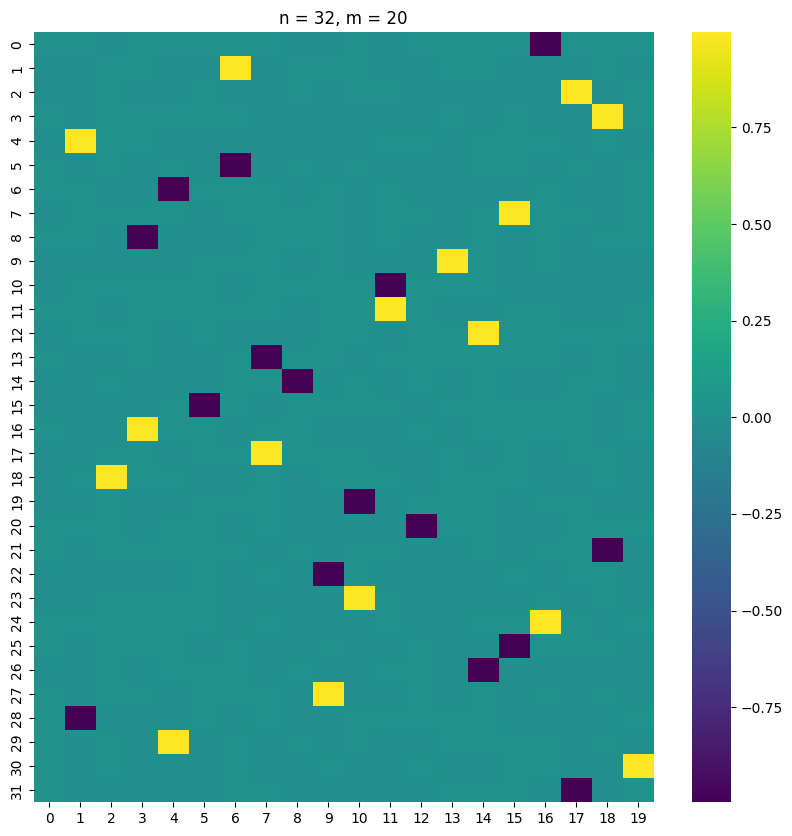

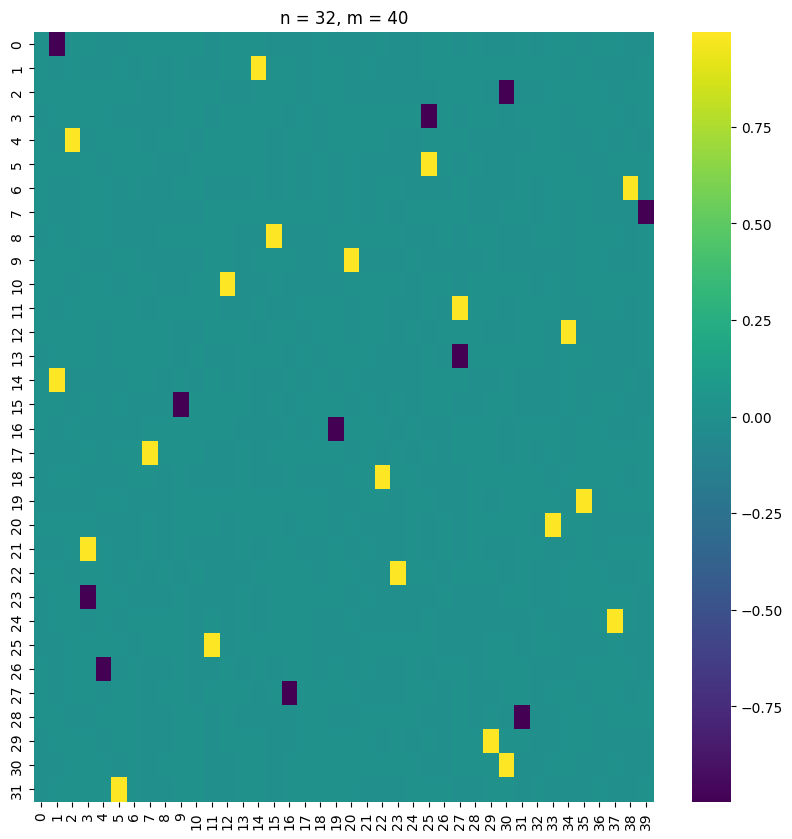

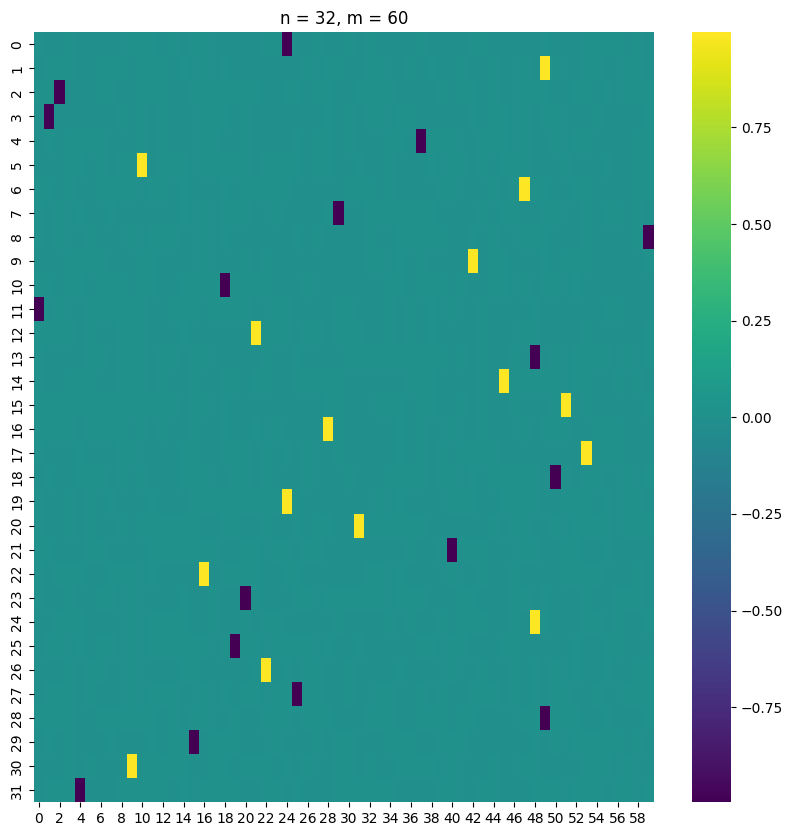

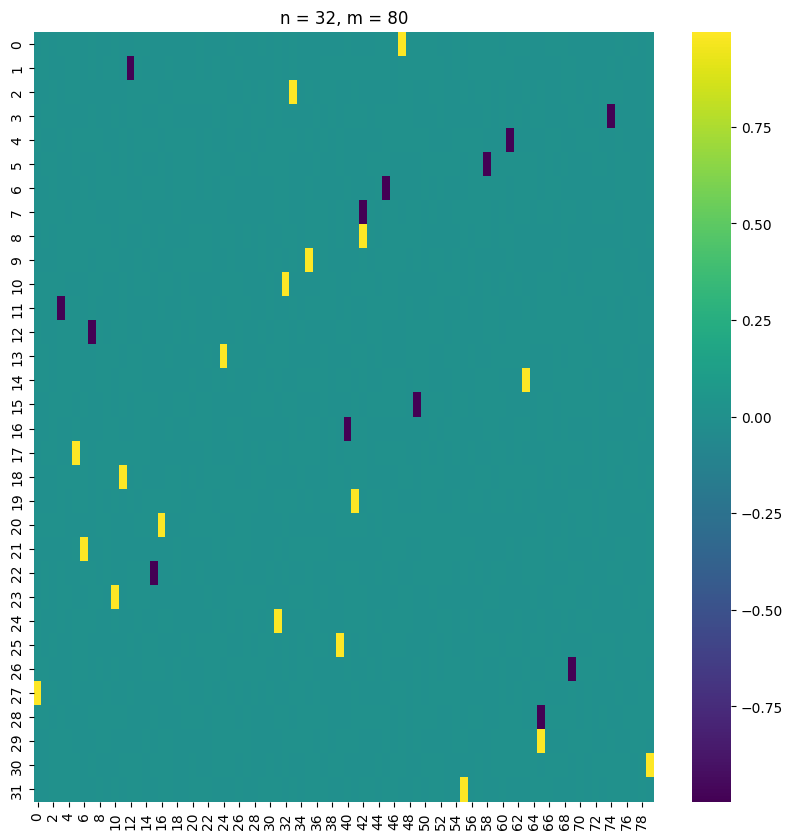

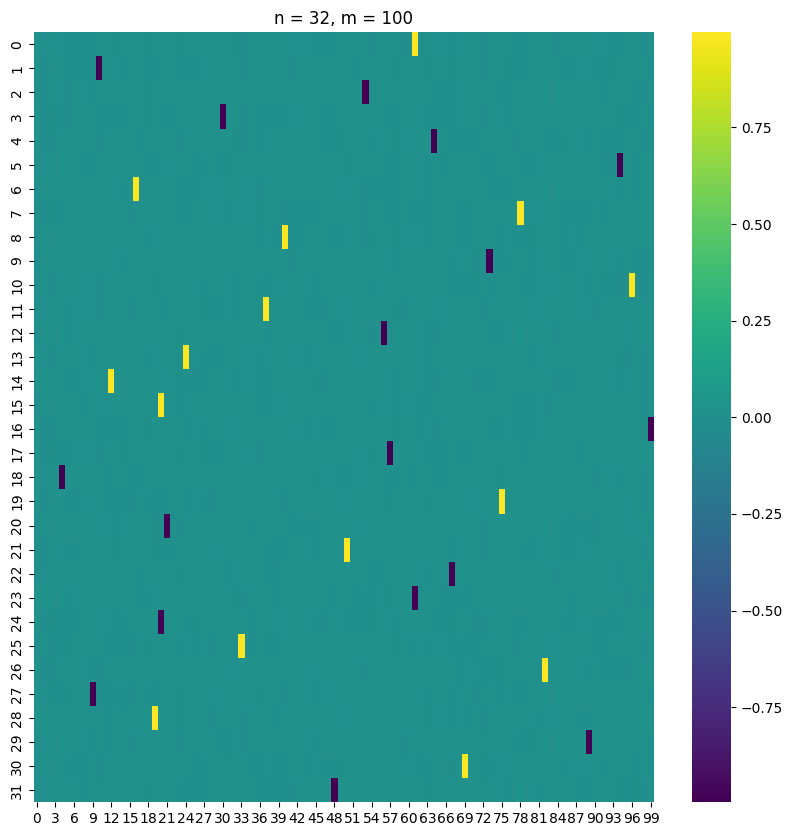

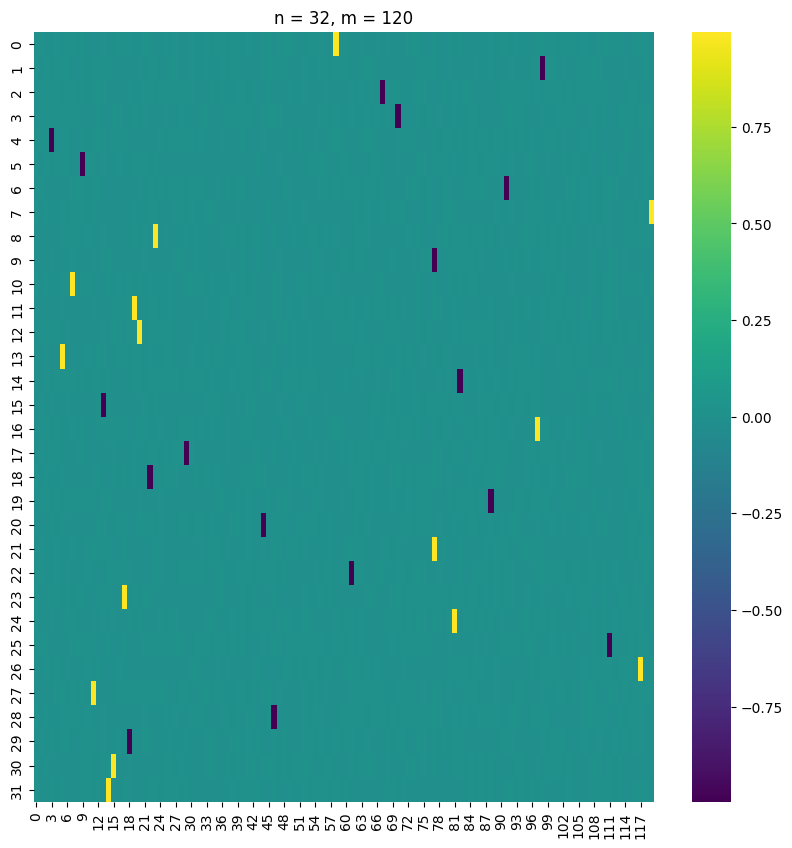

In [ ]:
## Existence of accidental polysemanticity
hidden_layer_sizes = [20, 40, 60, 80, 100, 120]

weight_matrices = []
neuron_activations = []
polysemantic_neuron_counts = []
heatmaps = []

for size in hidden_layer_sizes:
  config = Config(
      n_features=32,
      n_hidden=size,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.001)

  weight_matrix = model.W.detach().cpu().numpy()[0]
  weight_matrices.append(weight_matrix)
  absolute_matrix = np.abs(weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  total_activations = np.sum(activation_mask)
  neuron_activations.append(total_activations)

  # note we count polysemanticity by 0.8-1.2 here
  # this is because we expect to see 1 and -1
  neuron_activations_count = activation_mask.sum(axis=0)
  polysemantic_neurons_count = sum(1 for num in neuron_activations_count if num > 1.25)
  polysemantic_neuron_counts.append(polysemantic_neurons_count)

  plt.figure(figsize=(10,10))
  sns.heatmap(weight_matrix, cmap="viridis")
  plt.title(f"n = 32, m = {size}")
  heatmaps.append(plt.gcf())
print(neuron_activations)
print(polysemantic_neuron_counts)


In [ ]:
# Define the ranges you want to experiment with
ranges = [(0.7, 1.3), (0.8, 1.2), (0.9, 1.1)]

for r in ranges:
    low, high = r
    polysemantics_range = []
    for size in hidden_32:
        config = Config(
            n_features=32,
            n_hidden=size,
            n_instances=1,
            inputs="basis",
            tied=True,
            distri="normal",
            bias=False,
            nonlinear=True)

        model = Model(config=config, device=DEVICE)

        optimize(model, l1_factor=0.001)

        weight_matrix = model.W.detach().cpu().numpy()
        weight_matrix = weight_matrix[0]
        absolute_matrix = np.abs(weight_matrix)

        # Use the custom range for this experiment
        activation_mask = (absolute_matrix >= low) & (absolute_matrix <= high)
        count_total_activate = np.sum(activation_mask)

        # Count polysemanticity within the custom range
        count_neuron_activate = activation_mask.sum(axis=0)
        count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
        polysemantics_range.append(count_polysemantic)

    print(f"For range {r}, polysemantic neurons: {polysemantics_range}")


NameError: ignored

In [ ]:
def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             l1_factor = 0.001,
             track_polysemanticity=False,
             tracking_interval=1000):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  polysemanticity_history = []

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      importance = torch.ones(())
      error = (importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f ->i', 'mean').sum()
      if cfg.nonlinear:
        if cfg.tied:
          l1_norm = torch.norm(model.W, p=1)
        else:
          l1_norm = torch.norm(model.encoder, p=1) + torch.norm(model.decoder, p=1)
        loss = loss + l1_factor * l1_norm
      loss.backward()
      opt.step()

      if track_polysemanticity and step % tracking_interval == 0:
        weight_matrix = model.W.detach().cpu().numpy()[0]
        absolute_matrix = np.abs(weight_matrix)
        activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
        neuron_activations_count = activation_mask.sum(axis=0)
        polysemantic_neurons_count = sum(1 for num in neuron_activations_count if num > 1.25)
        polysemanticity_history.append(polysemantic_neurons_count)

      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(loss=loss.item(), lr=step_lr)

  return polysemanticity_history


  0%|          | 0/10000 [00:00<?, ?it/s]

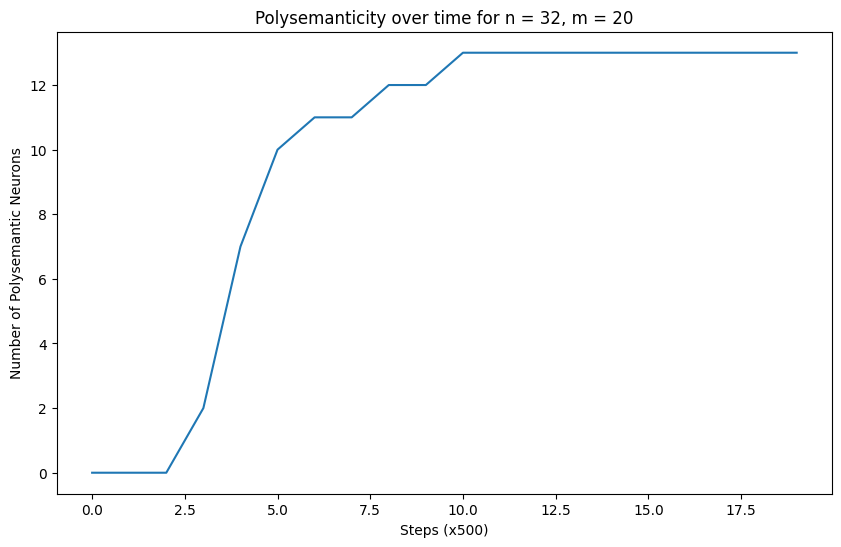

  0%|          | 0/10000 [00:00<?, ?it/s]

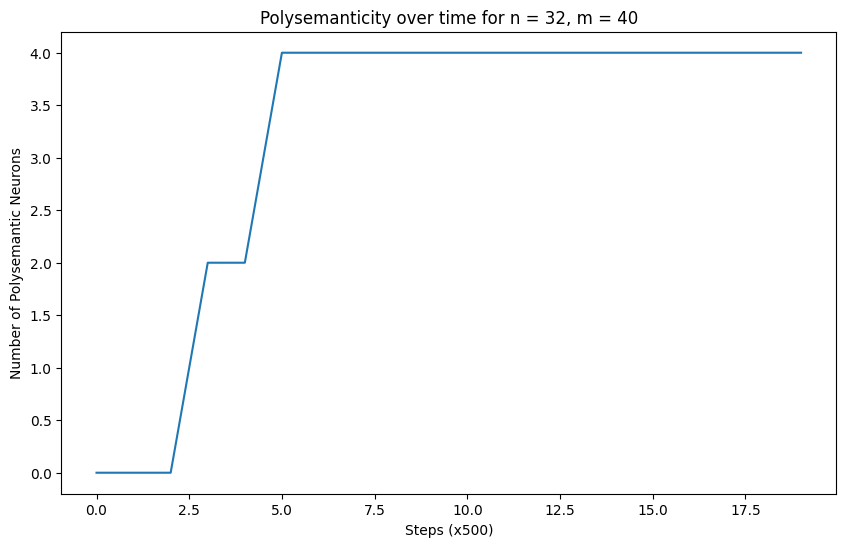

  0%|          | 0/10000 [00:00<?, ?it/s]

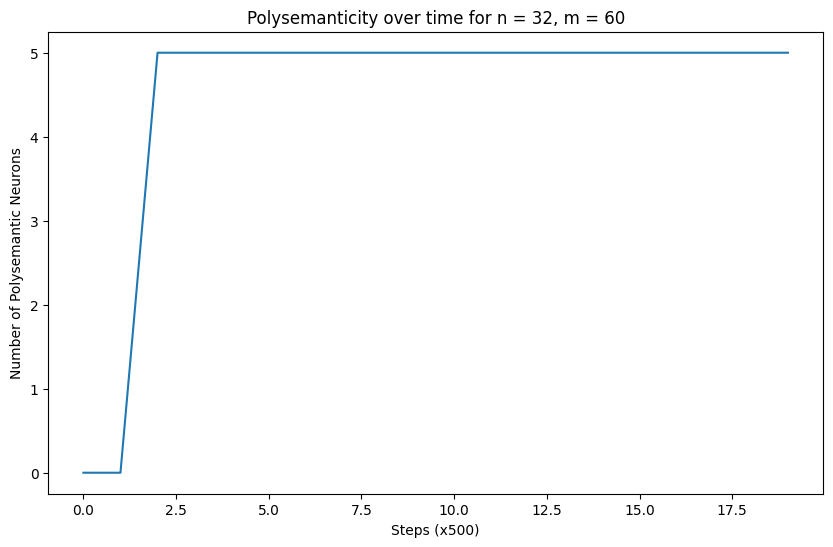

  0%|          | 0/10000 [00:00<?, ?it/s]

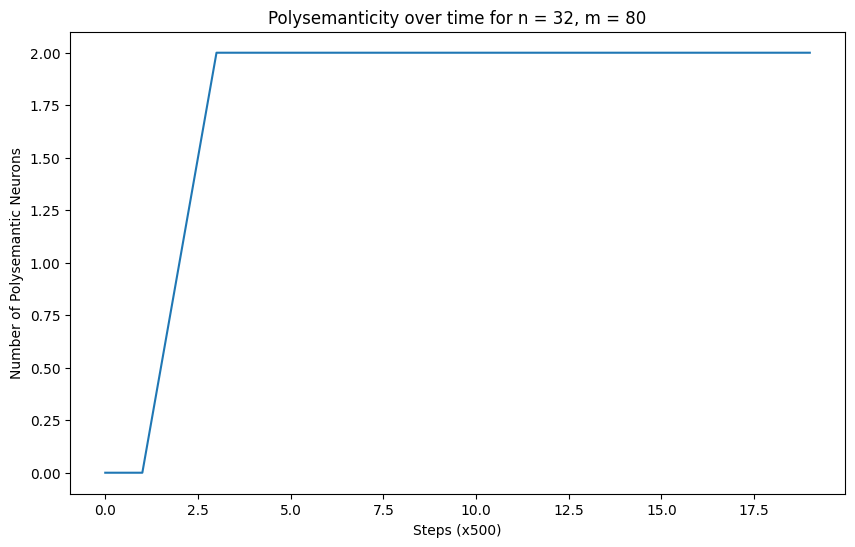

  0%|          | 0/10000 [00:00<?, ?it/s]

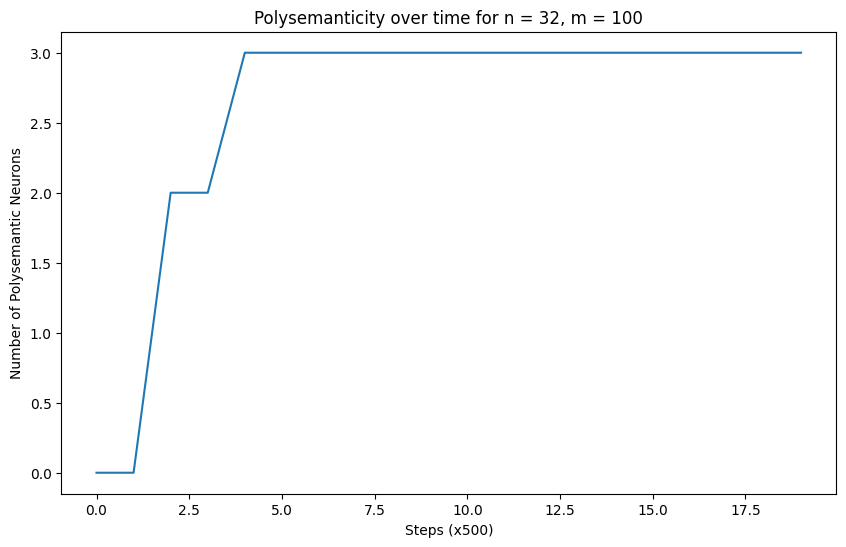

  0%|          | 0/10000 [00:00<?, ?it/s]

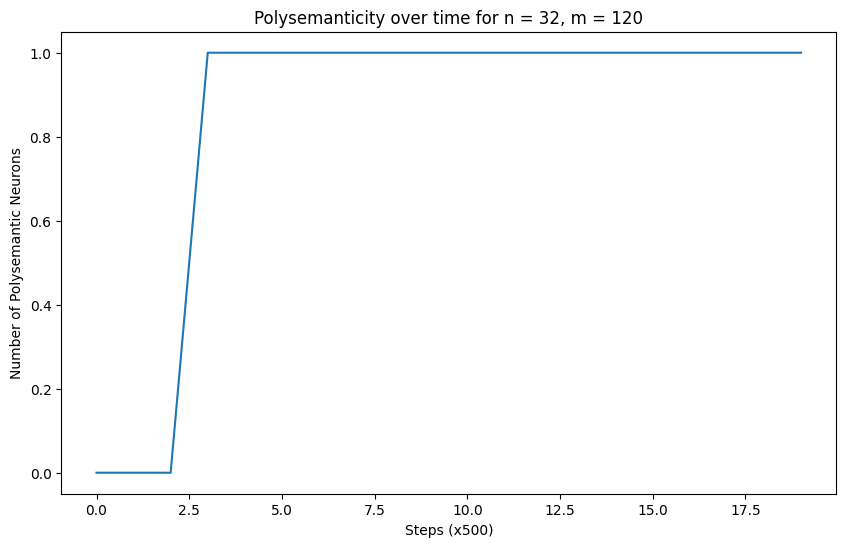

In [ ]:
hidden_layer_sizes = [20, 40, 60, 80, 100, 120]

for size in hidden_layer_sizes:
    config = Config(
        n_features=32,
        n_hidden=size,
        n_instances=1,
        inputs="basis",
        tied=True,
        distri="normal",
        bias=False,
        nonlinear=True)

    model = Model(
        config=config,
        device=DEVICE)

    polysemanticity_history = optimize(model, l1_factor=0.001, track_polysemanticity=True, tracking_interval=500)

    plt.figure(figsize=(10,6))
    plt.plot(polysemanticity_history)
    plt.title(f"Polysemanticity over time for n = 32, m = {size}")
    plt.xlabel("Steps (x500)")
    plt.ylabel("Number of Polysemantic Neurons")
    plt.show()


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[64, 64, 64, 64, 64, 64]
[16, 5, 7, 3, 4, 3]


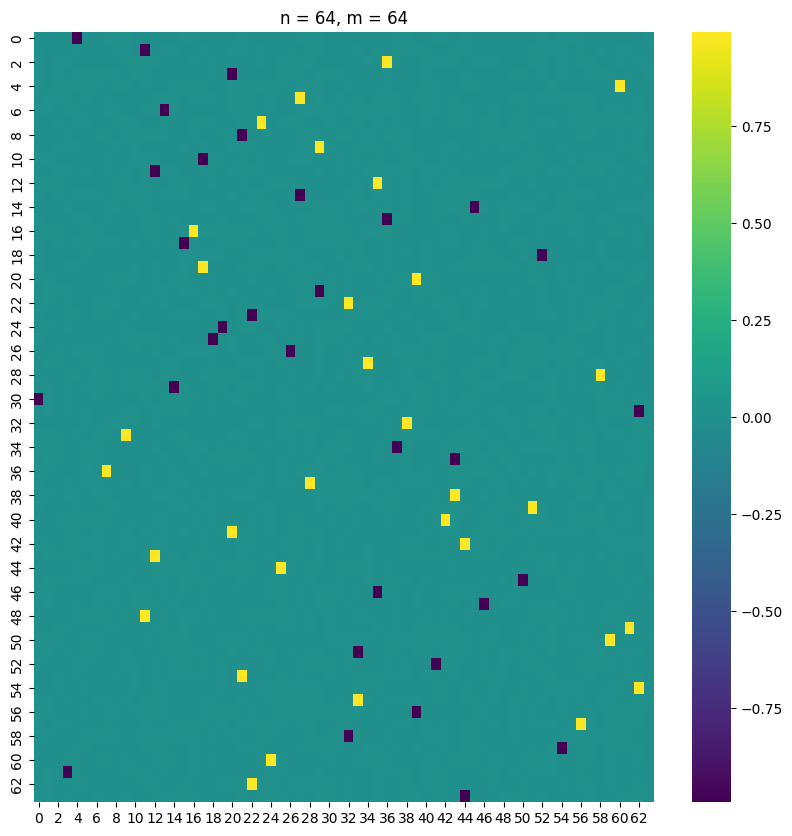

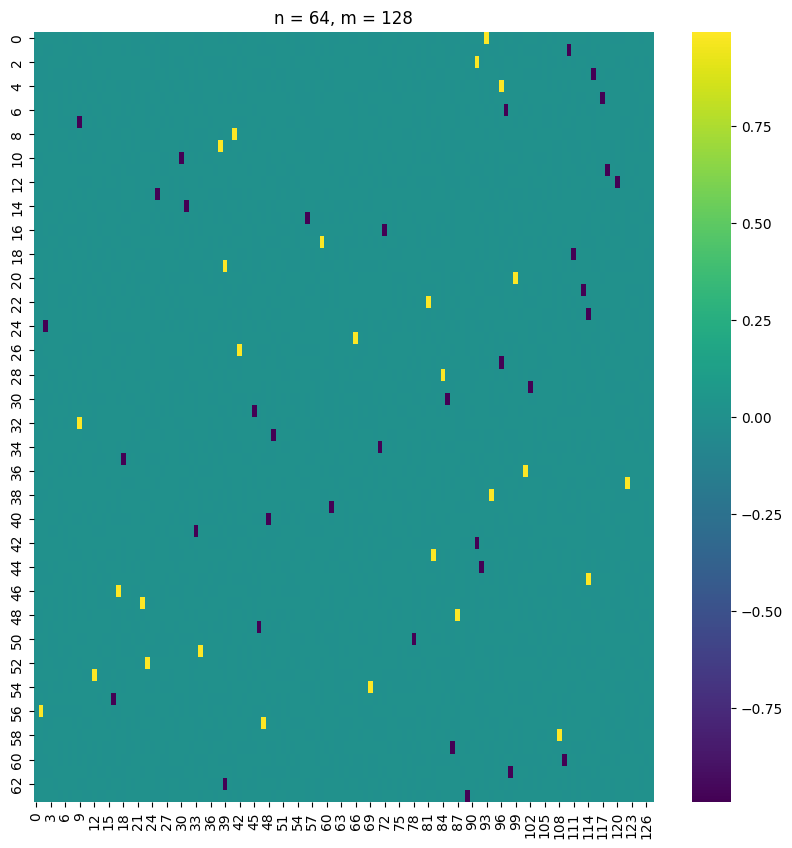

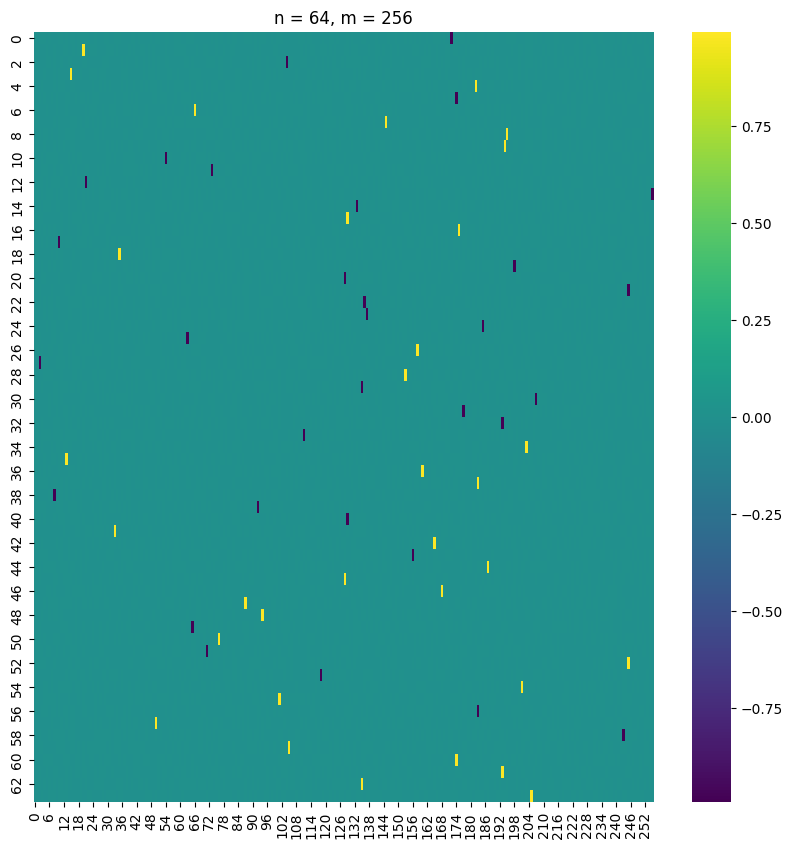

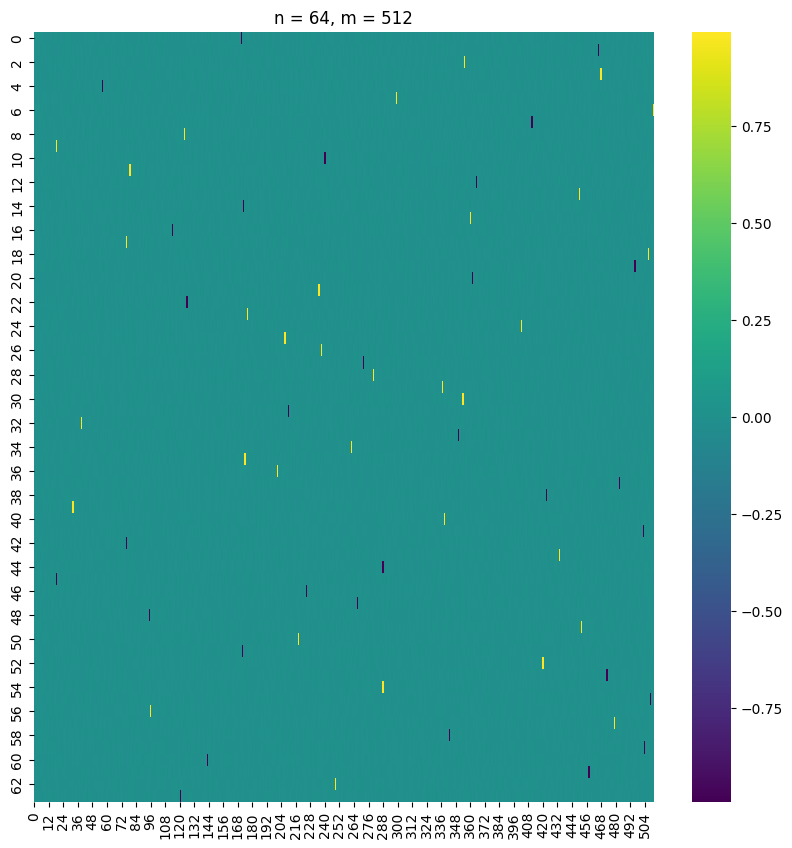

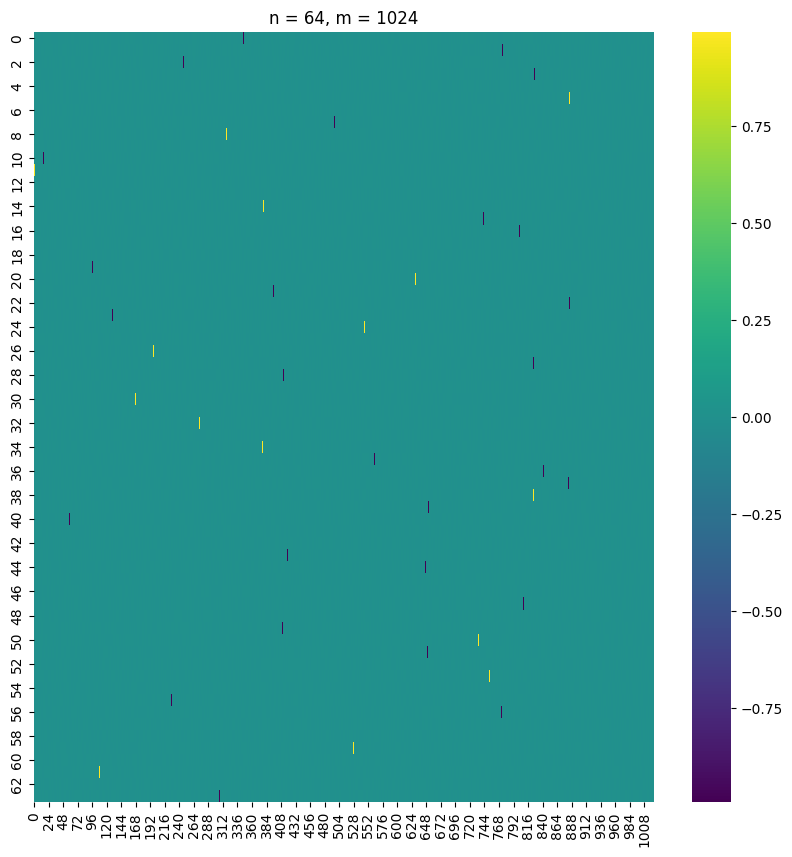

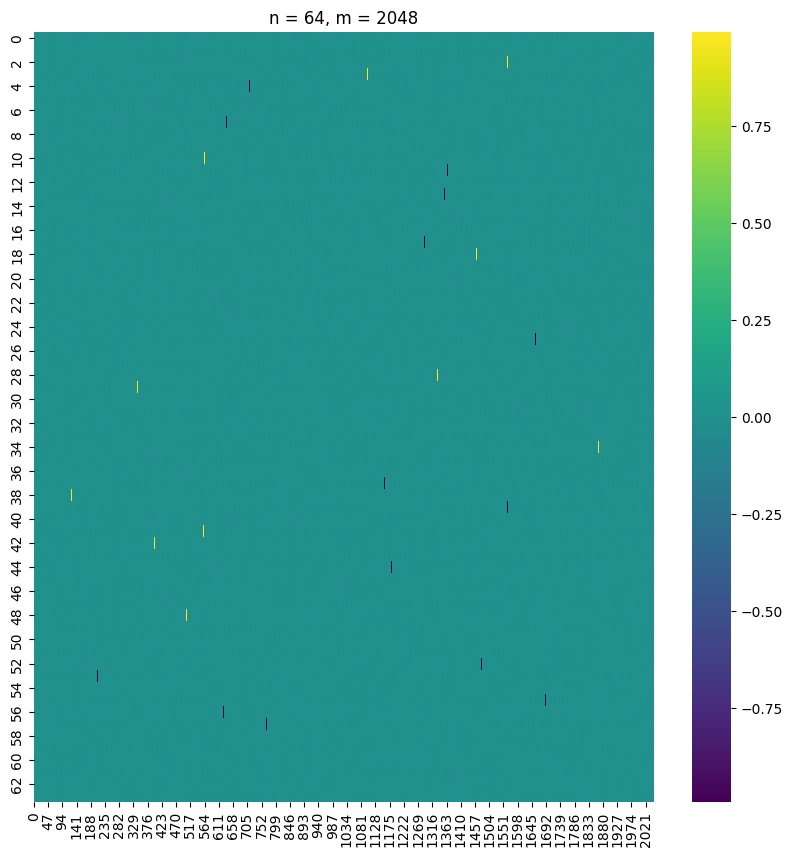

In [ ]:
## Confirming the random initialisations hypothesis
hidden_neurons = [64, 128, 256, 512, 1024, 2048]

initial_weights = []
final_weights = []
total_activations = []
polysemantic_counts = []
weight_plots = []

for num_hidden in hidden_neurons:
  config = Config(
      n_features=64,
      n_hidden=num_hidden,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.001)

  start_weight_matrix = model.W_initial.detach().cpu().numpy()[0]
  initial_weights.append(start_weight_matrix)

  final_weight_matrix = model.W.detach().cpu().numpy()[0]
  final_weights.append(final_weight_matrix)

  absolute_matrix = np.abs(final_weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  total_active_neurons = np.sum(activation_mask)
  total_activations.append(total_active_neurons)

  num_active_neurons_per_neuron = activation_mask.sum(axis=0)
  num_polysemantic = sum(1 for num in num_active_neurons_per_neuron if num > 1.25)
  polysemantic_counts.append(num_polysemantic)

  plt.figure(figsize=(10,10))
  sns.heatmap(final_weight_matrix, cmap="viridis")
  plt.title(f"n = 64, m = {num_hidden}")
  weight_plots.append(plt.gcf())

print(total_activations)
print(polysemantic_counts)
correlation_plots = []

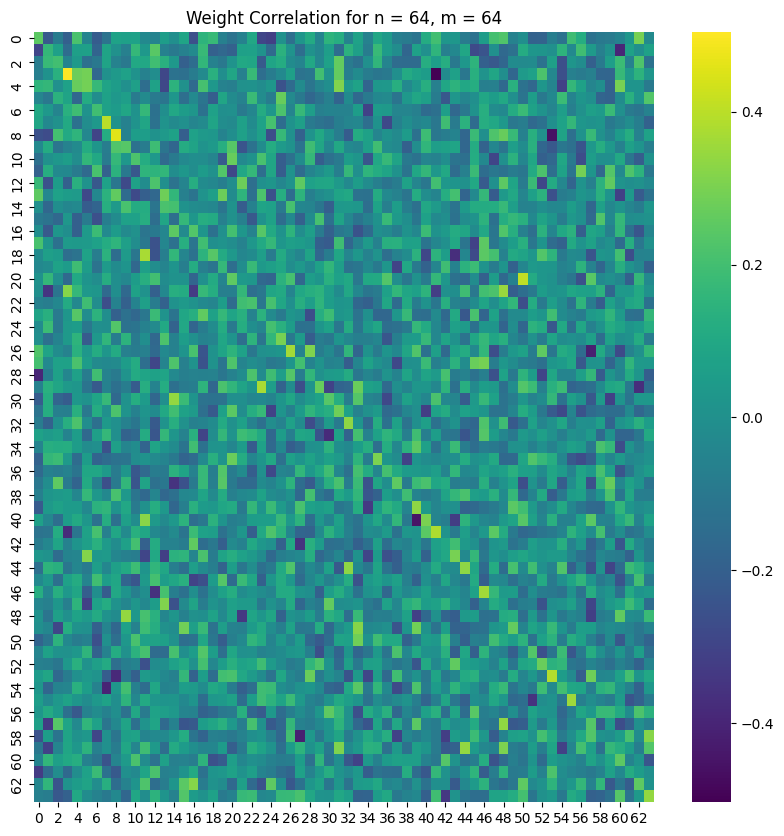

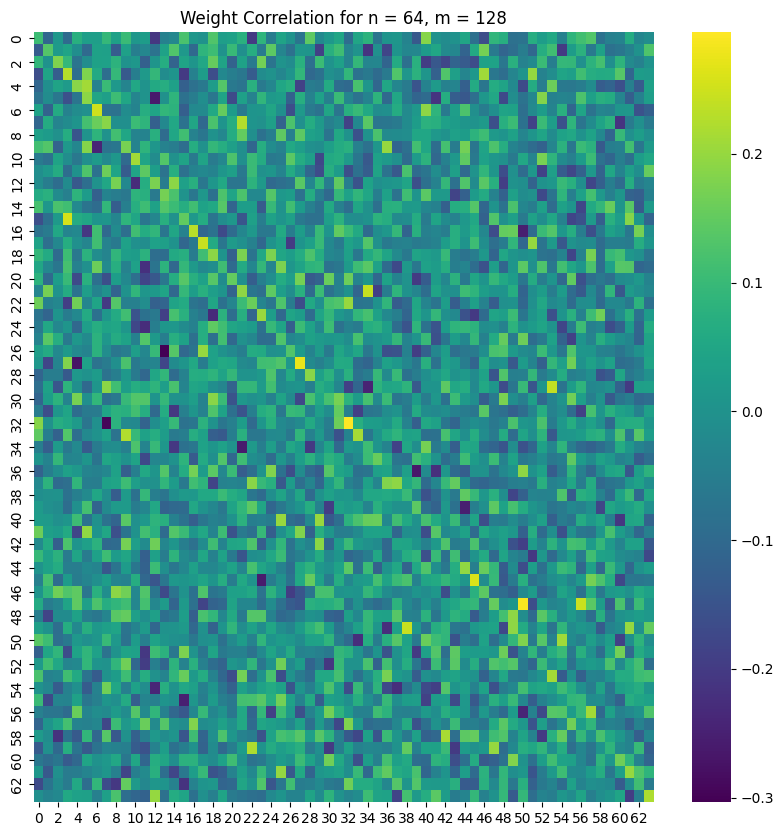

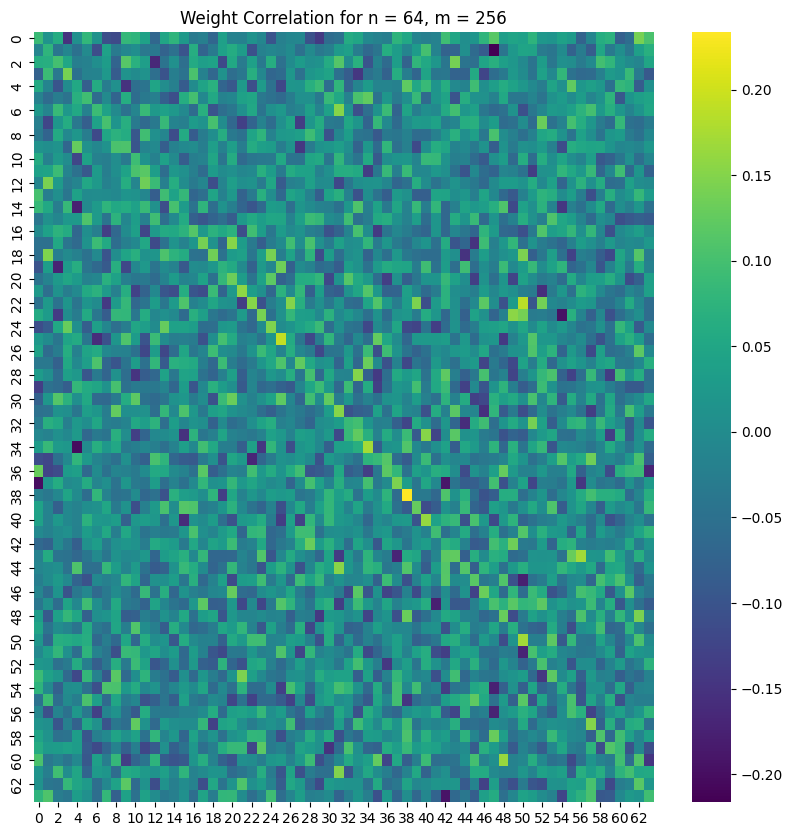

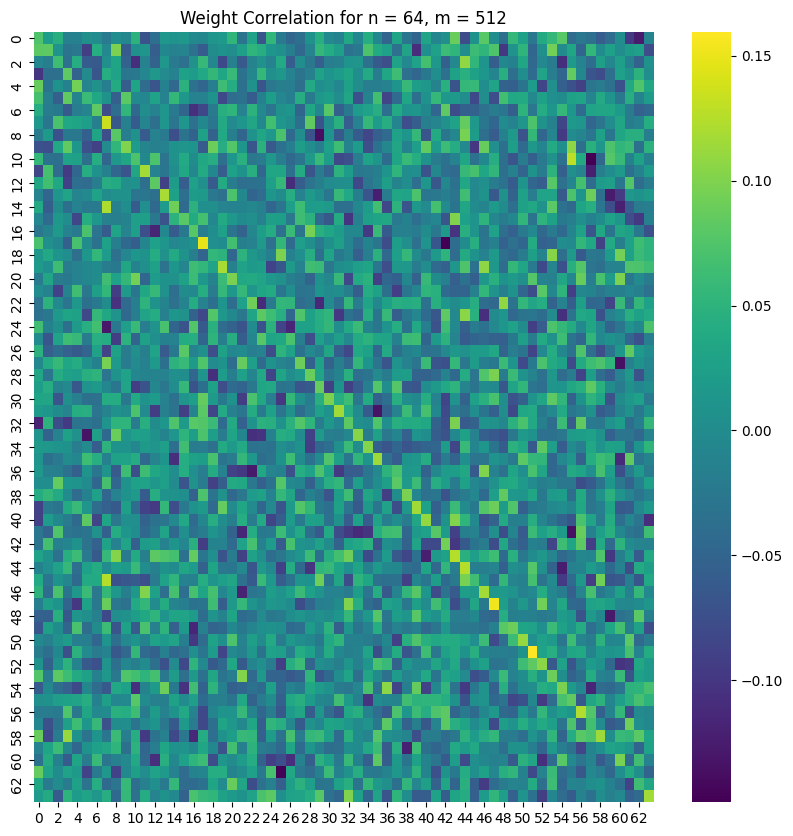

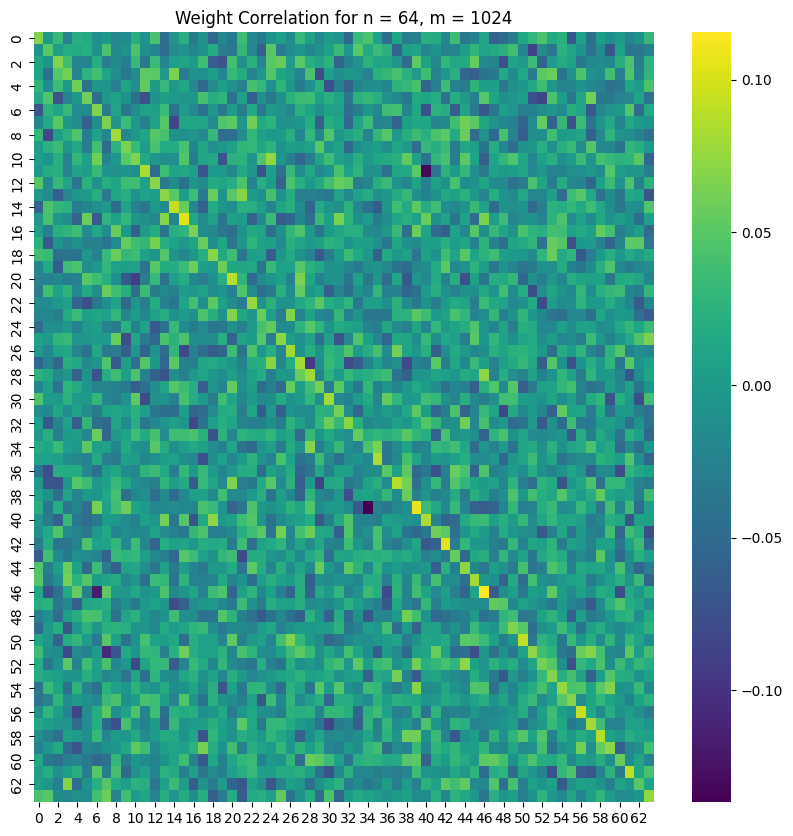

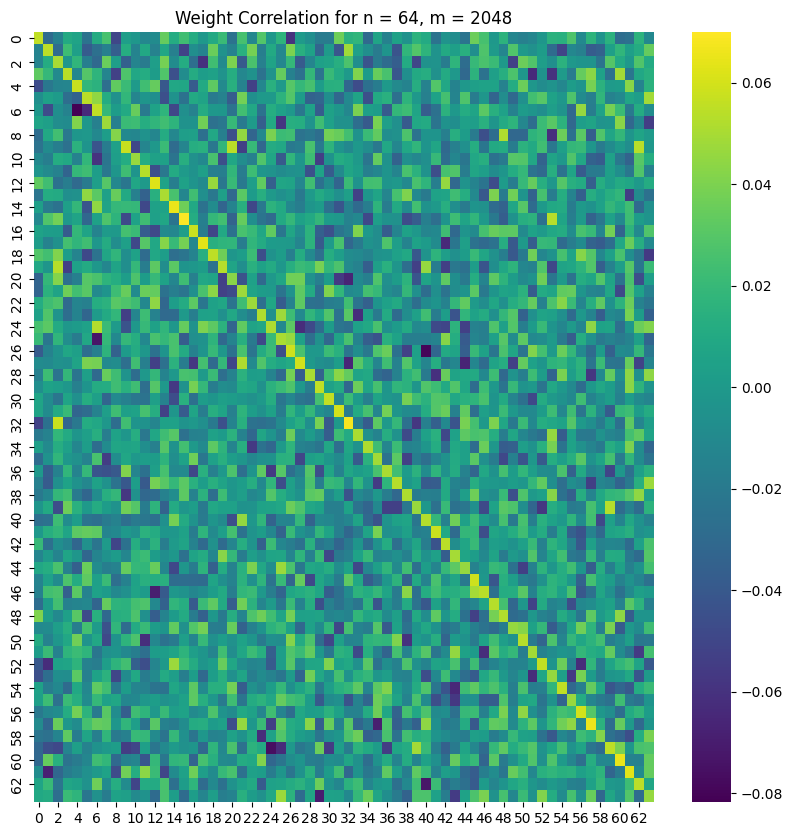

In [ ]:
for num_hidden, initial_weight, final_weight in zip(hidden_neurons, initial_weights, final_weights):
  correlation_matrix = initial_weight @ final_weight.T
  plt.figure(figsize=(10,10))
  sns.heatmap(correlation_matrix, cmap="viridis")
  plt.title(f"Weight Correlation for n = 64, m = {num_hidden}")
  correlation_plots.append(plt.gcf())


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
[69, 26, 19, 12, 11, 7, 6, 10, 6, 5, 5, 4, 4, 2, 3, 1]


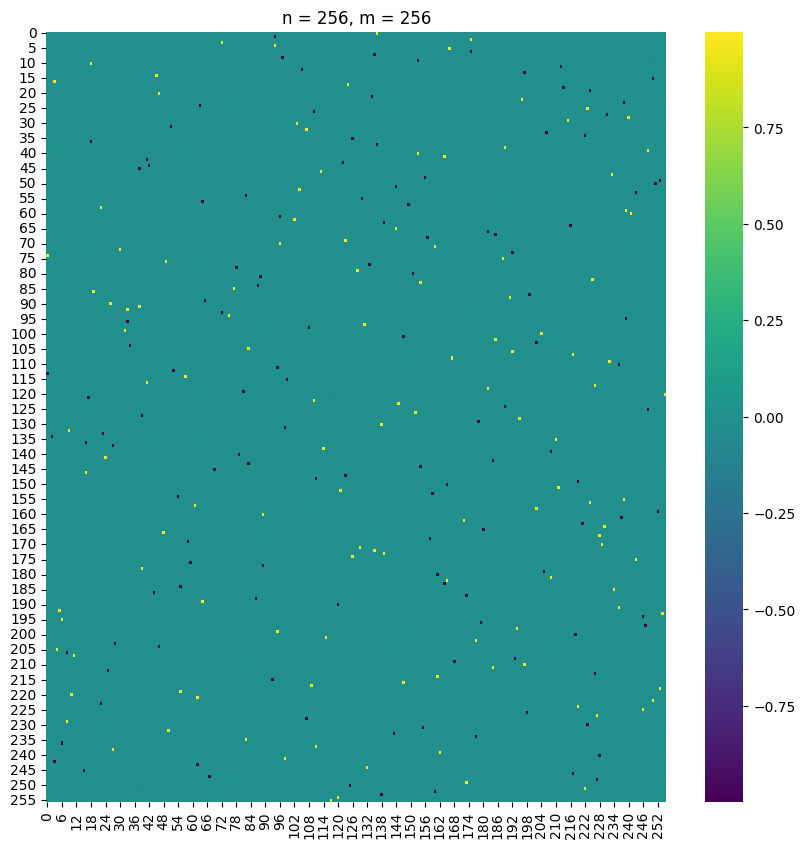

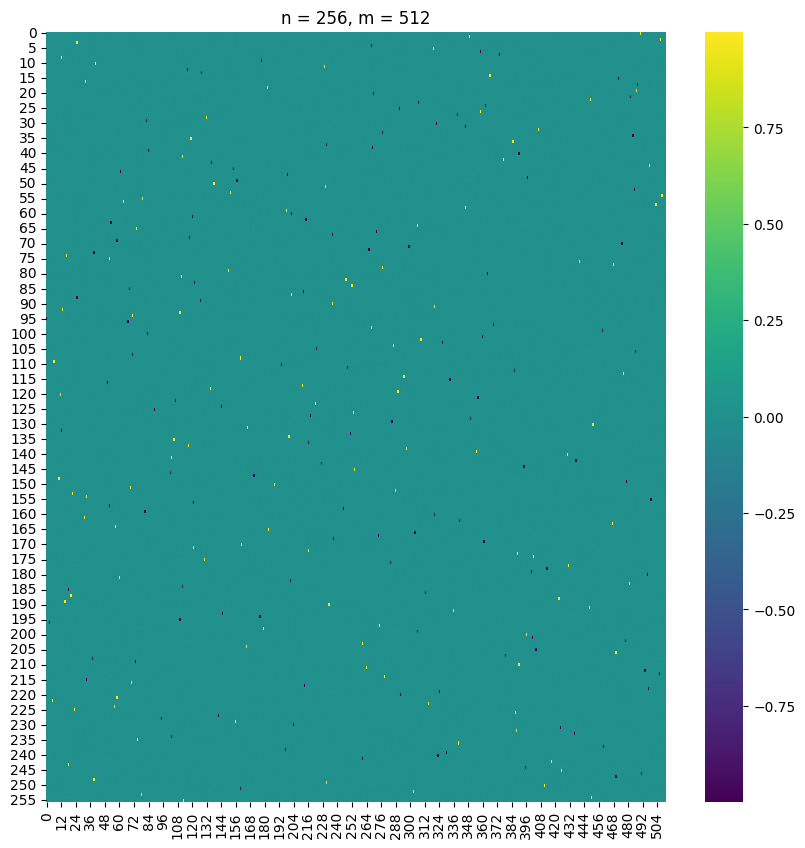

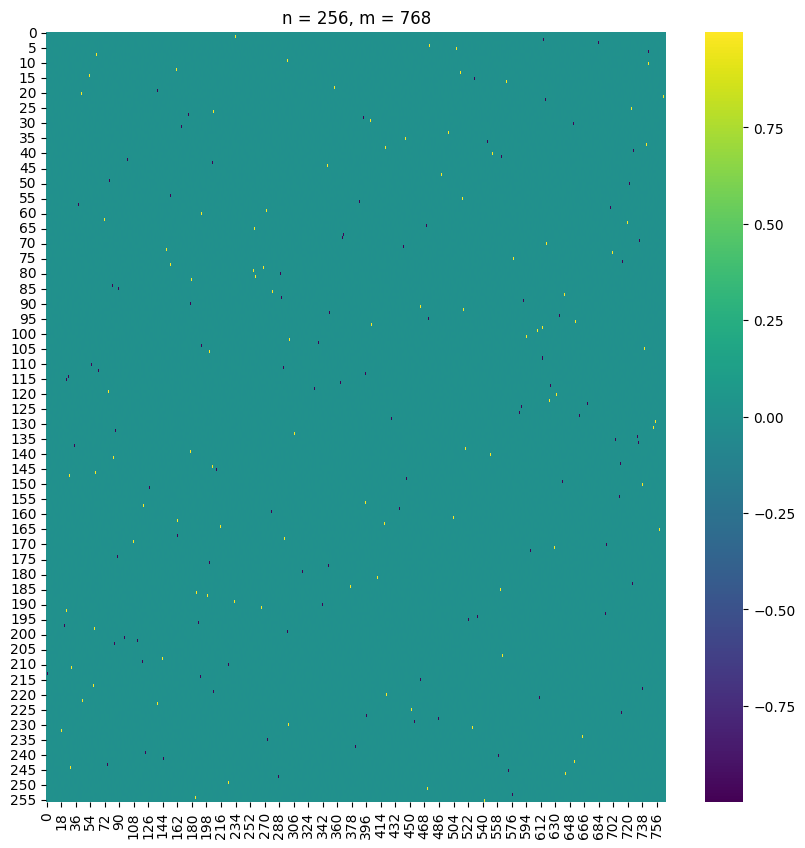

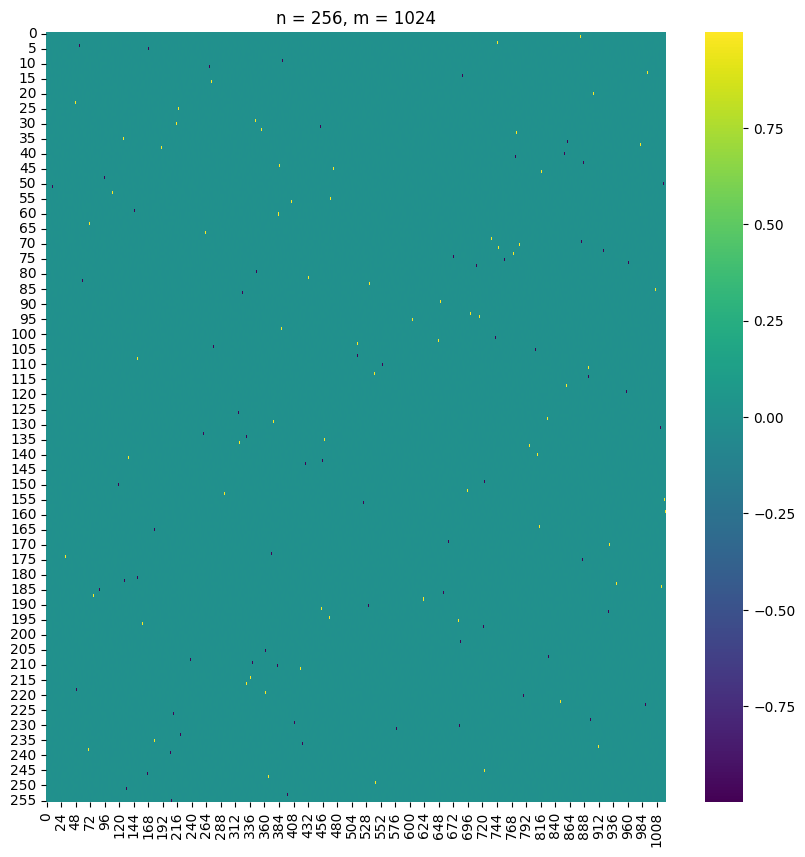

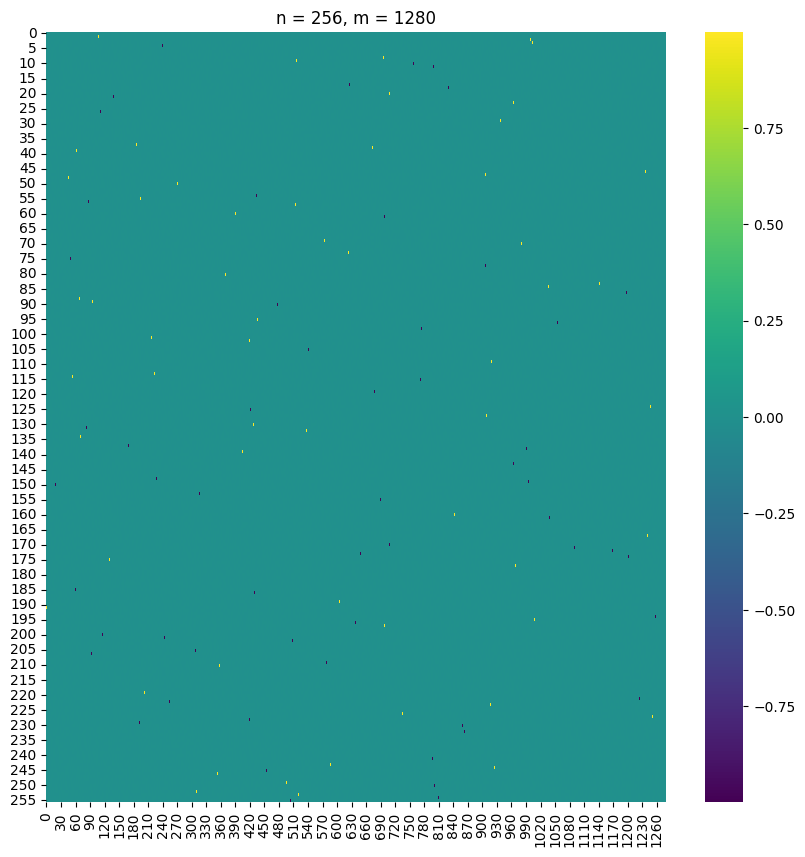

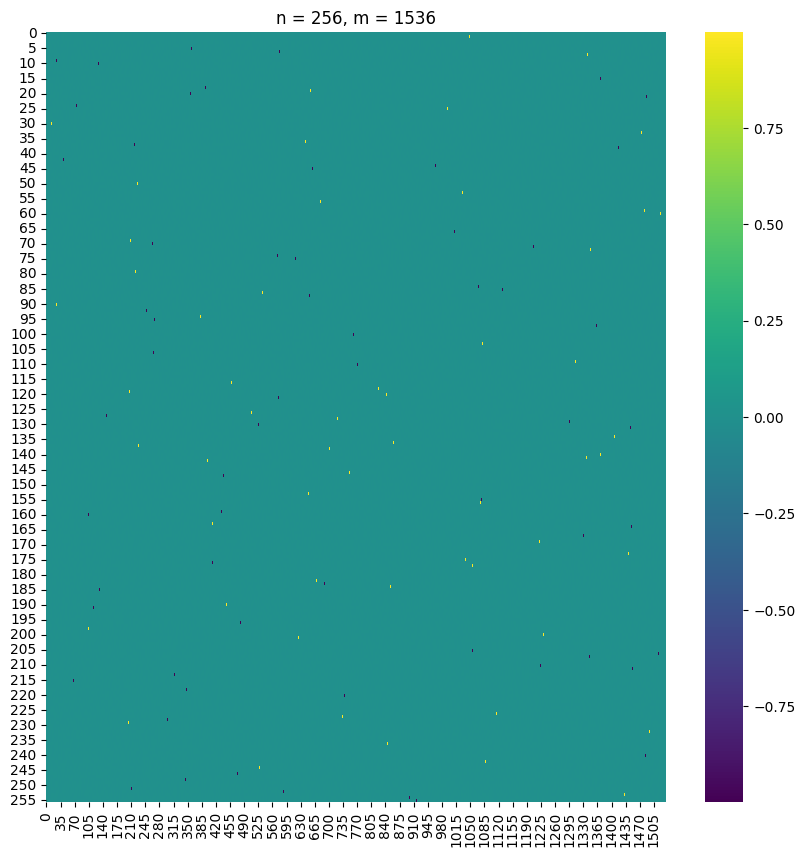

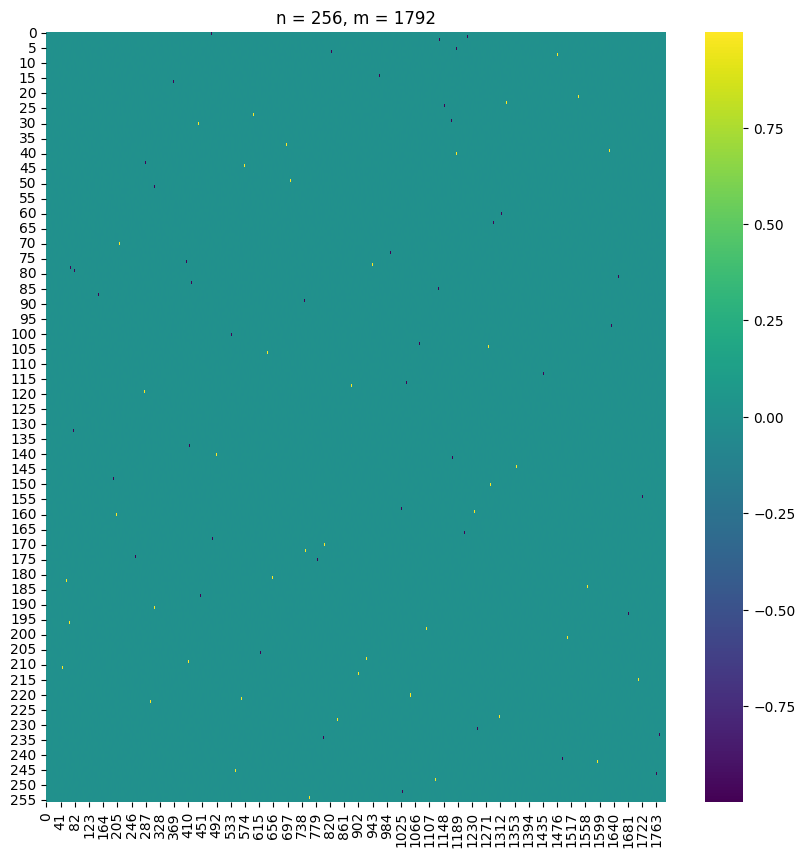

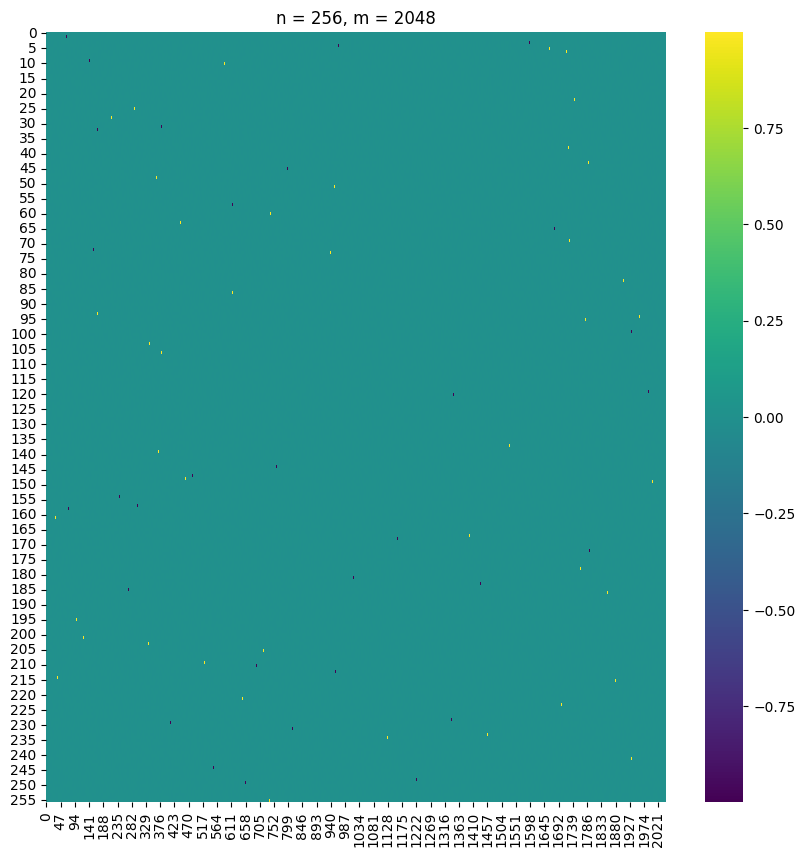

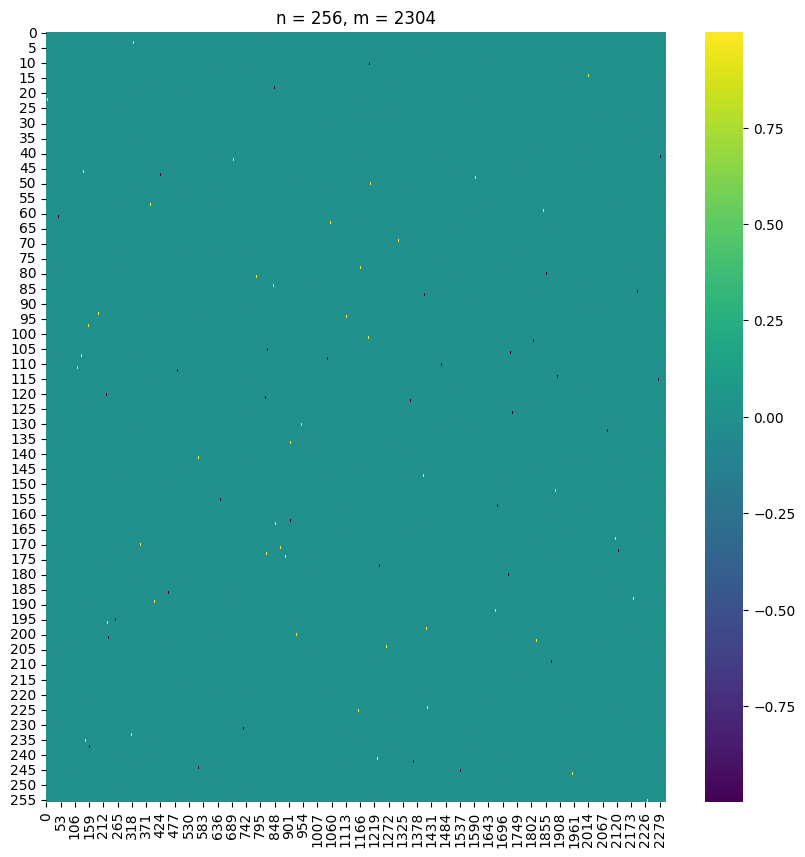

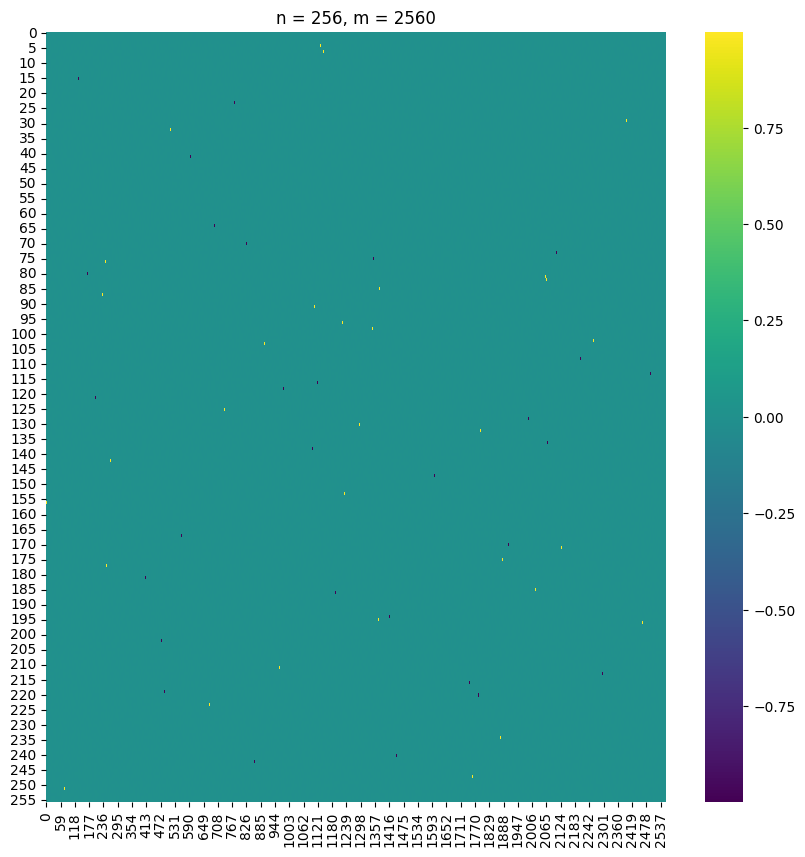

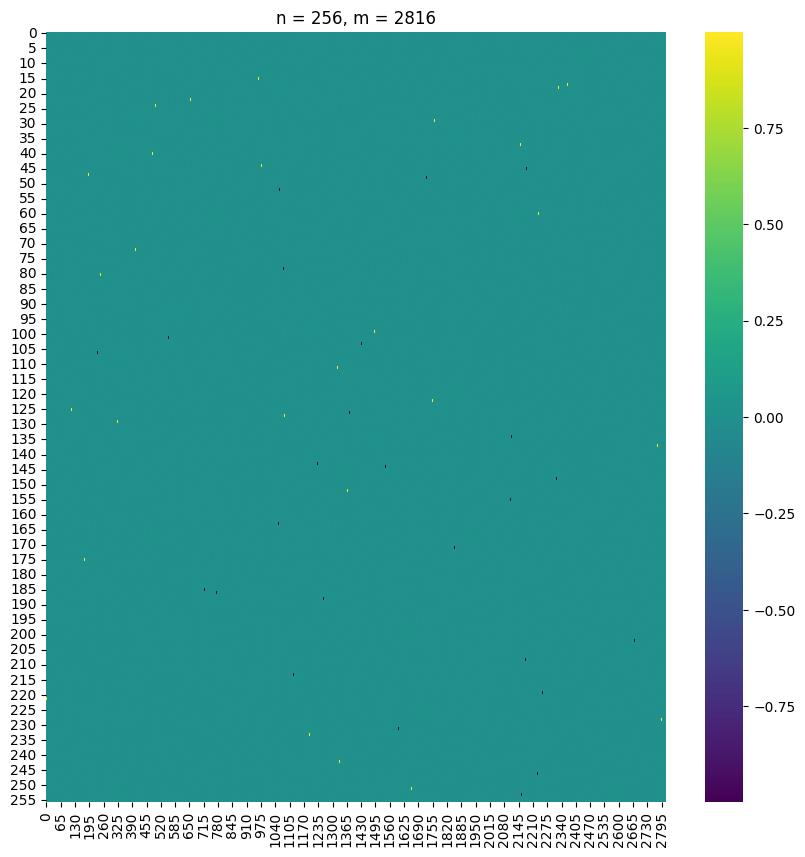

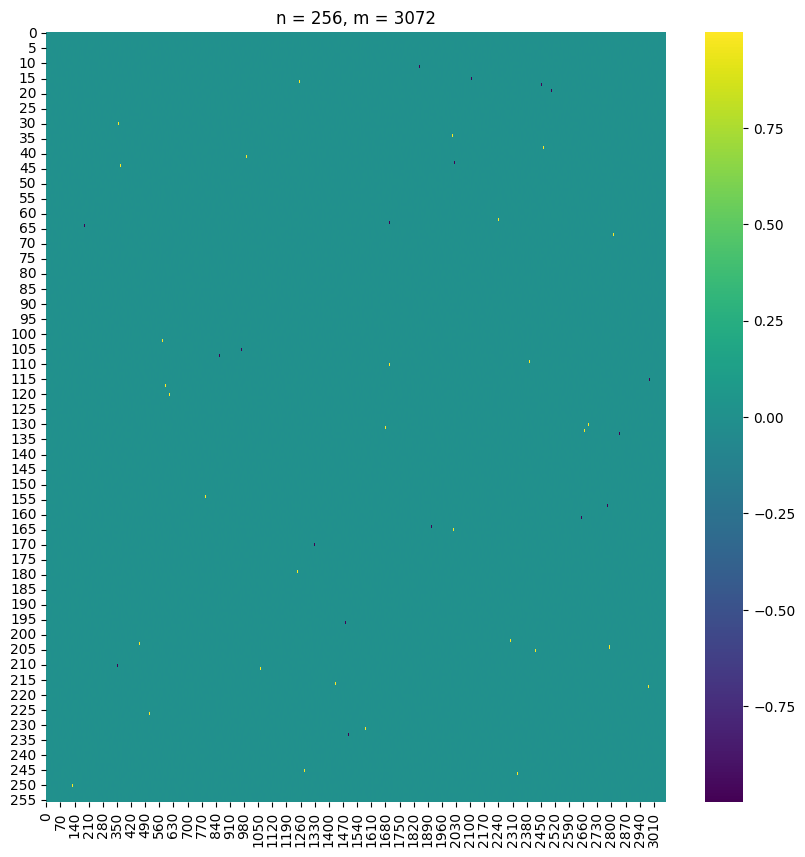

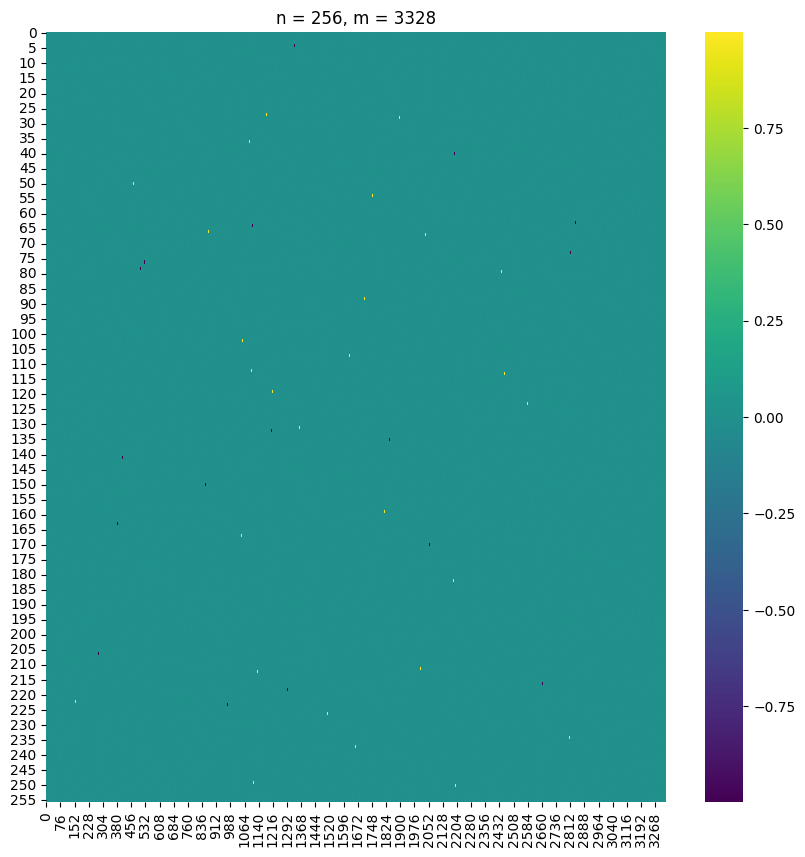

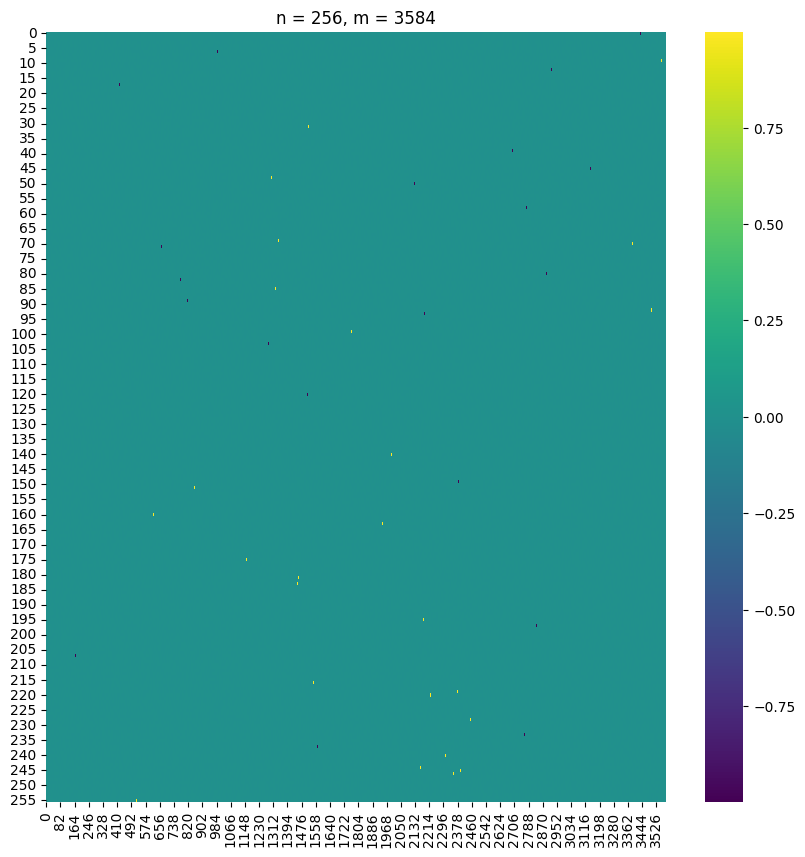

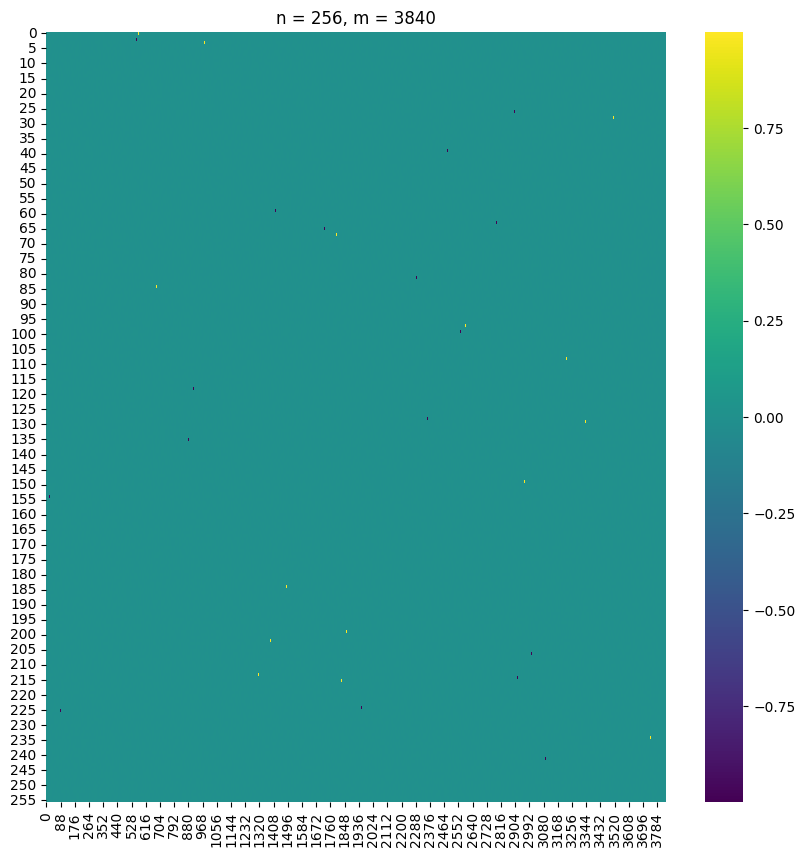

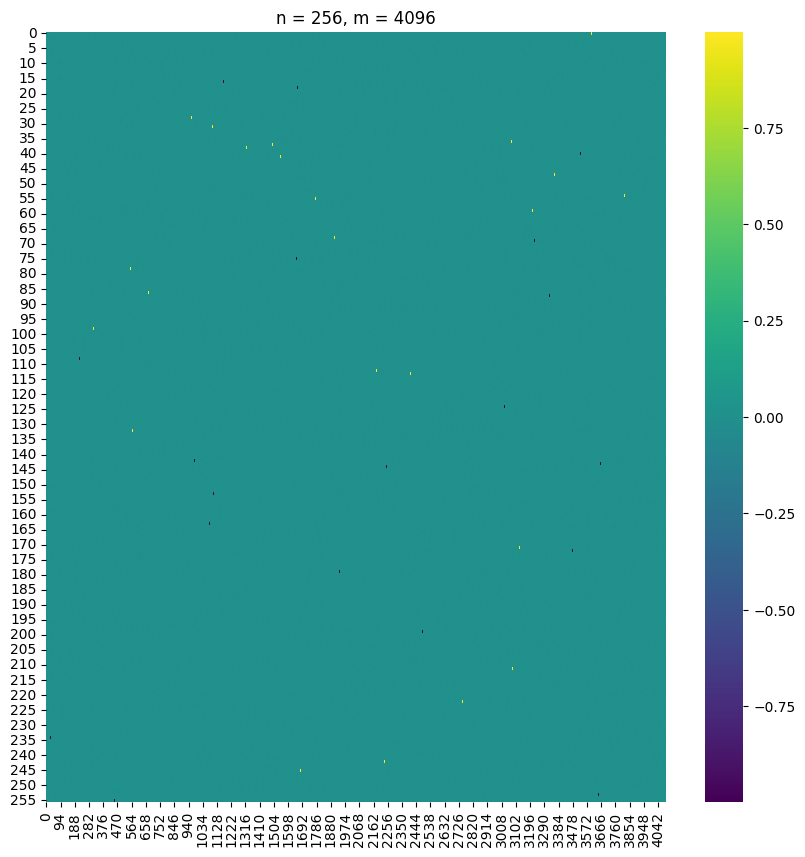

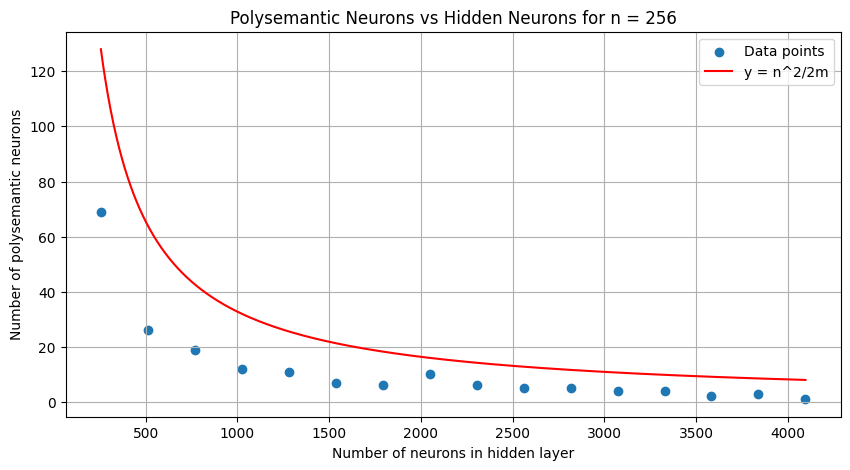

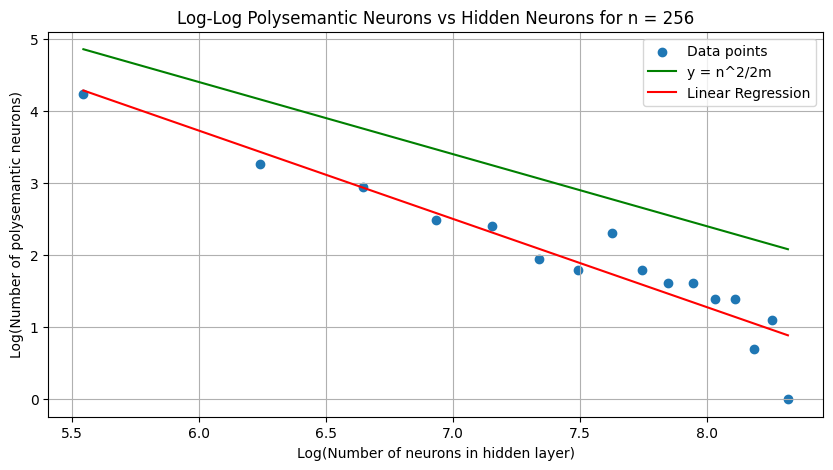

Coefficients:  [-1.22420642 11.0686525 ]


In [ ]:

## Quantifying the amount of polysemanticity
hidden_256 = [256, 512, 768, 1024, 1280, 1536, 1792, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096]

start_weights_256 = []
weights_256 = []
activations_256 = []
polysemantics_256 = []
plots_256 = []

for size in hidden_256:
  config = Config(
      n_features=256,
      n_hidden=size,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.00005)

  start_matrix = model.W_initial.detach().cpu().numpy()
  start_matrix = start_matrix[0]
  start_weights_256.append(start_matrix)

  weight_matrix = model.W.detach().cpu().numpy()
  weight_matrix = weight_matrix[0]
  weights_256.append(weight_matrix)
  absolute_matrix = np.abs(weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  count_total_activate = np.sum(activation_mask)
  activations_256.append(count_total_activate)

  # note we count polysemanticity by 0.8-1.2 here
  # this is because we expect to see 1 and -1
  count_neuron_activate = activation_mask.sum(axis=0)
  count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
  polysemantics_256.append(count_polysemantic)

  plt.figure(figsize=(10,10))
  sns.heatmap(weight_matrix, cmap="viridis")
  plt.title(f"n = 256, m = {size}")
  plots_256.append(plt.gcf())
print(activations_256)
print(polysemantics_256)
x = np.array(hidden_256)
y = np.array(polysemantics_256)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Data points')

x_line = np.linspace(min(x), max(x), 1000)  # Equally spaced points between min and max of x
y_line = 65536 / (2 * x_line)  # 256 squared divided by 2
plt.plot(x_line, y_line, color='r', label='y = n^2/2m')

plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Number of polysemantic neurons')
plt.title('Polysemantic Neurons vs Hidden Neurons for n = 256')
plt.grid(True)
plt.legend()
plt.show()
log_x = np.log(x)
log_y = np.log(y)
log_x_line = np.log(x_line)
log_y_line = np.log(y_line)

coefficients = np.polyfit(log_x, log_y, 1)
regression_line = np.polyval(coefficients, log_x)

plt.figure(figsize=(10, 5))
plt.scatter(log_x, log_y, label='Data points')
plt.plot(log_x_line, log_y_line, color='green', label='y = n^2/2m')
plt.plot(log_x, regression_line, color='red', label='Linear Regression')
plt.xlabel('Log(Number of neurons in hidden layer)')
plt.ylabel('Log(Number of polysemantic neurons)')
plt.title('Log-Log Polysemantic Neurons vs Hidden Neurons for n = 256')
plt.grid(True)
plt.legend()
plt.show()

print("Coefficients: ", coefficients)

  0%|          | 0/10000 [00:00<?, ?it/s]

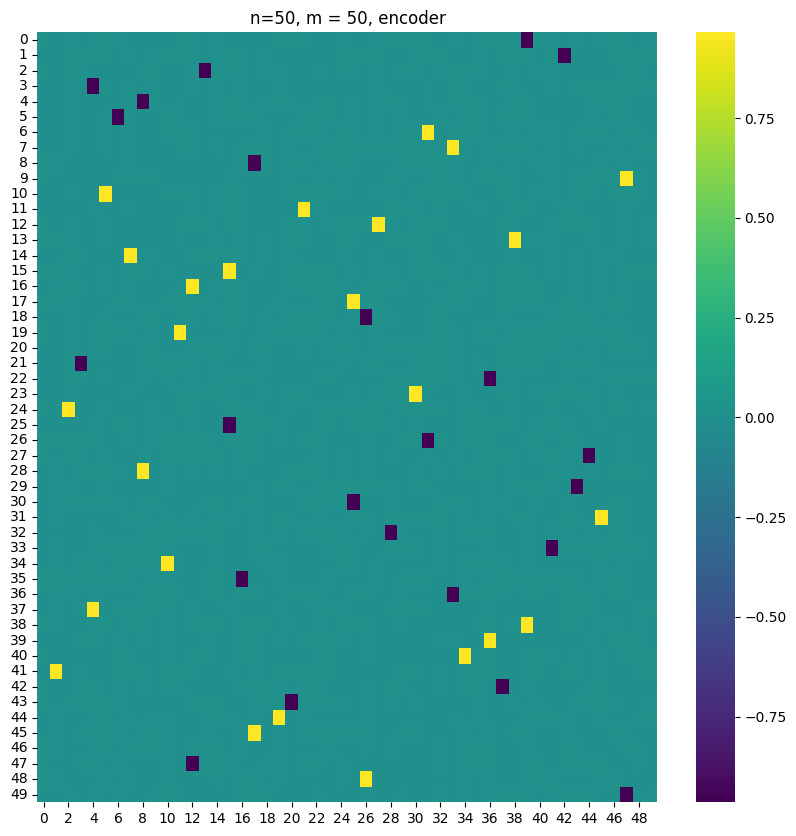

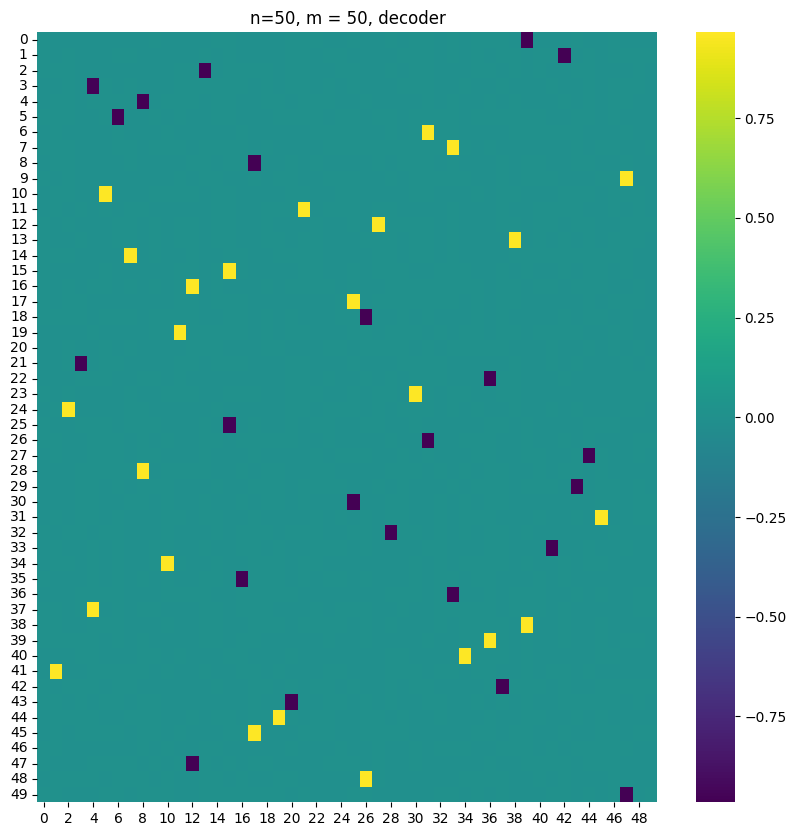

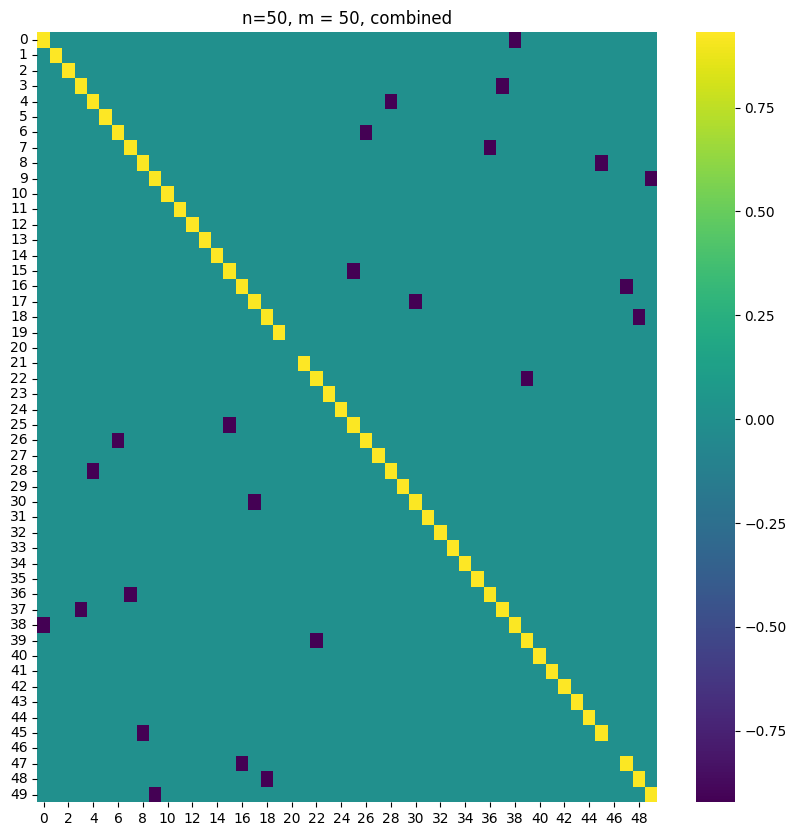

  0%|          | 0/10000 [00:00<?, ?it/s]

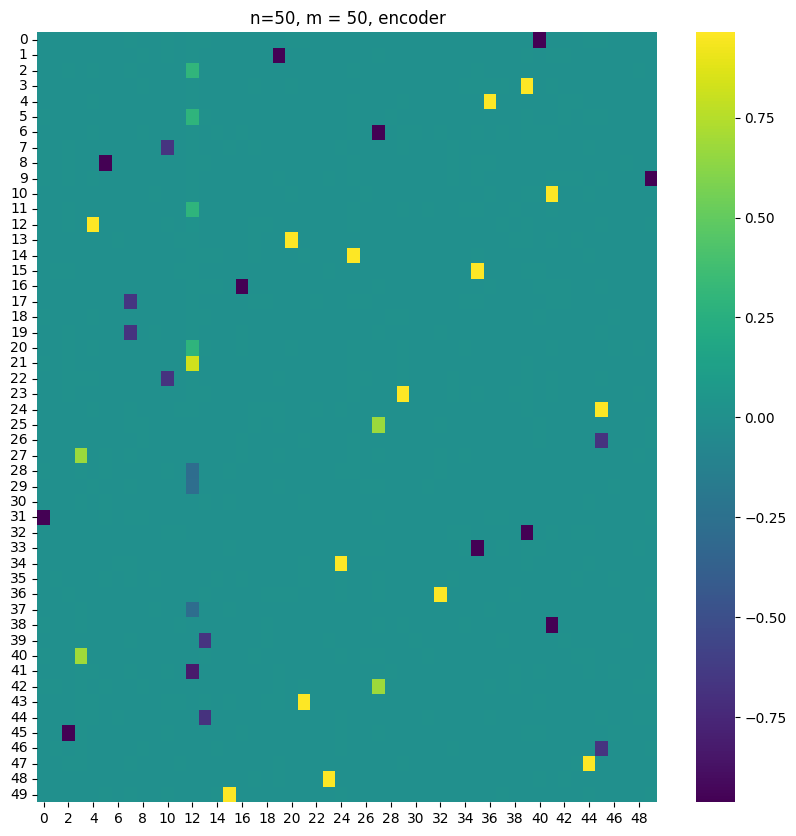

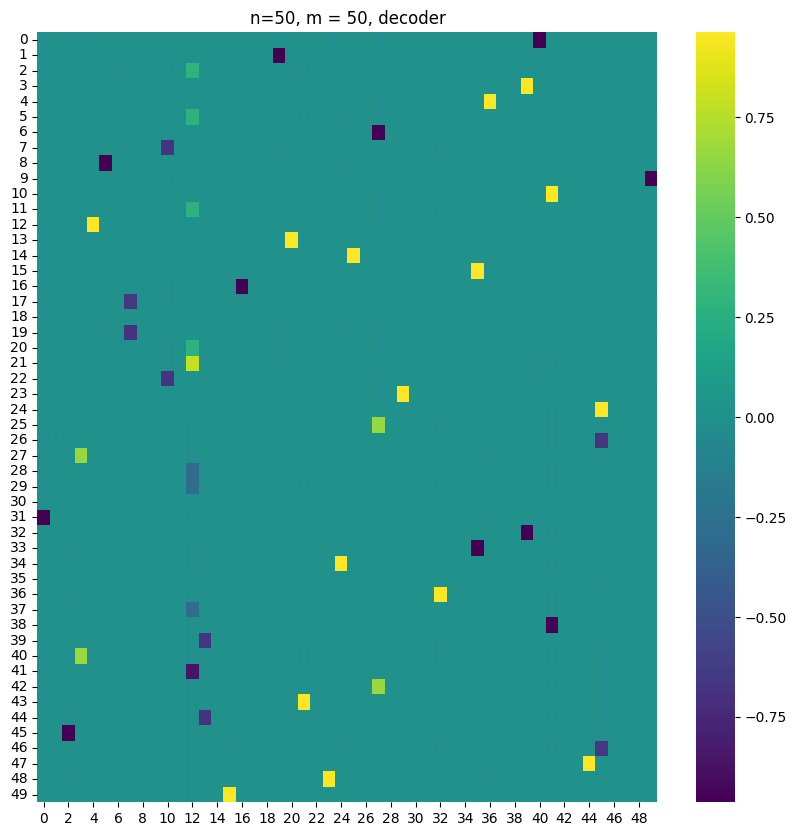

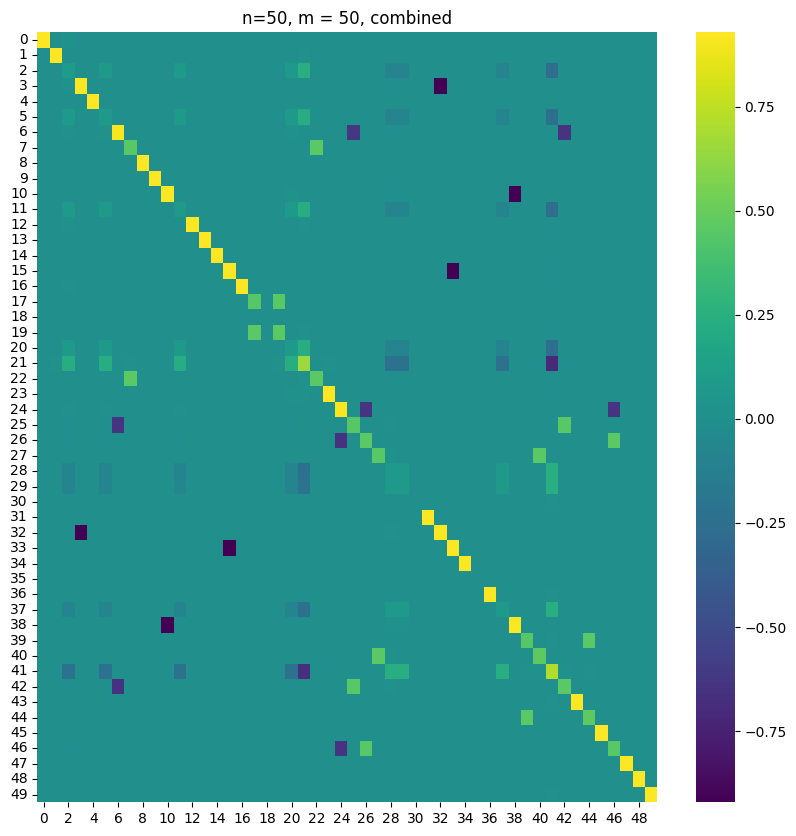

In [ ]:

## Inducing the identity matrix for correlated features
hidden_50 = [50]

encoder_50 = []
decoder_50 = []
bias_50 = []

for size in hidden_50:
  config = Config(
      n_features=50,
      n_hidden=size,
      n_instances=1,
      inputs="correlated",
      tied=False,
      distri="normal",
      bias=True,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, n_batch=100, l1_factor=0.0005)

  encoder_matrix = model.encoder.detach().cpu().numpy()
  encoder_matrix = encoder_matrix[0]
  encoder_50.append(encoder_matrix)

  decoder_matrix = model.decoder.detach().cpu().numpy()
  decoder_matrix = decoder_matrix[0]
  decoder_50.append(decoder_matrix)

  bias_vector = model.bias.detach().cpu().numpy()
  bias_50.append(bias_vector)
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, encoder")
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(decoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, decoder")
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0] @ decoder_50[0].T, cmap="viridis")
plt.title("n=50, m = 50, combined")
plt.show()
## Inducing lossless polysemanticity with correlated features
hidden_50 = [50]

encoder_50 = []
decoder_50 = []
bias_50 = []

for size in hidden_50:
  config = Config(
      n_features=50,
      n_hidden=size,
      n_instances=1,
      inputs="correlated",
      tied=False,
      distri="xavier",
      bias=True,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, n_batch=100, l1_factor=0.0005)

  encoder_matrix = model.encoder.detach().cpu().numpy()
  encoder_matrix = encoder_matrix[0]
  encoder_50.append(encoder_matrix)

  decoder_matrix = model.decoder.detach().cpu().numpy()
  decoder_matrix = decoder_matrix[0]
  decoder_50.append(decoder_matrix)

  bias_vector = model.bias.detach().cpu().numpy()
  bias_50.append(bias_vector)
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, encoder")
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(decoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, decoder")
plt.show()
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0] @ decoder_50[0].T, cmap="viridis")
plt.title("n=50, m = 50, combined")
plt.show()

Sure, let's breakdown the two experiments:

### Experiment 1: Inducing an Identity Matrix for Correlated Features

In this experiment, the aim is to train an autoencoder model to learn an identity matrix, which is a way to avoid polysemanticity. Each neuron in the identity matrix corresponds to one specific feature, thus avoiding the case where one neuron responds to multiple features. The steps are as follows:

1. **Set up the configuration**: Define the configuration for the model. The configuration includes the number of features, the number of hidden neurons, whether the weights are tied or not, the distribution for weight initialization, the use of bias, and whether a nonlinear activation function (ReLU) is used. Also, the input is set to "correlated", which implies that the inputs are not independent but correlated.

2. **Initialize the model**: With the given configuration, initialize the autoencoder model.

3. **Optimize the model**: Train the model using a modified version of the AdamW optimizer. The optimization process includes adjusting the learning rate and applying L1 regularization. Here, the loss function is the mean squared error between the input and output, with an additional term for L1 regularization to encourage sparsity.

4. **Visualize the learned weights**: After training, the weights of the encoder, decoder, and the combined weights (product of encoder and decoder weights) are visualized using heatmaps. If the model has successfully learned an identity matrix, the heatmap of the combined weights should resemble an identity matrix.

### Experiment 2: Inducing Lossless Polysemanticity with Correlated Features

In this experiment, the aim is to train an autoencoder model in such a way that it allows neurons to capture multiple features, essentially inducing polysemanticity. This is done by changing the initialization distribution to 'xavier' and setting 'tied' to False. The steps are similar to the first experiment, with the main difference lying in the configuration:

1. **Set up the configuration**: The configuration is similar to the first experiment, but with two main changes. First, the initialization distribution is changed from 'normal' to 'xavier'. Xavier initialization is designed to keep the scale of the gradients roughly the same in all layers. Second, the weights are not tied in this experiment, meaning the encoder and decoder have separate weights.

2. **Initialize the model**: As in the first experiment, initialize the model with the given configuration.

3. **Optimize the model**: Train the model using the same optimization process as the first experiment.

4. **Visualize the learned weights**: After training, visualize the learned weights of the encoder, decoder, and the combined weights. If the model has successfully induced polysemanticity, the heatmap of the combined weights would show that multiple neurons are responding to the same features.

By comparing the results of these two experiments, you can gain insights into how different configurations and training strategies affect the degree of polysemanticity in the model.

Instead of just looking at the end result, analyze the training dynamics. How does polysemanticity develop over time during training? Are there any specific patterns or phases?

In [ ]:
def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             checkpoint_freq=500,  # new parameter to specify checkpoint frequency
             lr=1e-3,
             lr_scale=constant_lr,
             l1_factor = 0.001):

  # define lists to hold the checkpoint data
  weight_checkpoints = []
  activation_checkpoints = []
  polysemantic_checkpoints = []

  # rest of the function setup...

  with trange(steps) as t:
    for step in t:
      # regular optimization code...

      # checkpointing code
      if step % checkpoint_freq == 0:
        weight_matrix = model.W.detach().cpu().numpy()
        weight_matrix = weight_matrix[0]
        absolute_matrix = np.abs(weight_matrix)

        activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
        count_total_activate = np.sum(activation_mask)
        count_neuron_activate = activation_mask.sum(axis=0)
        count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)

        weight_checkpoints.append(weight_matrix)
        activation_checkpoints.append(count_total_activate)
        polysemantic_checkpoints.append(count_polysemantic)

  # at the end of training, return the checkpoint data along with any other necessary info
  return weight_checkpoints, activation_checkpoints, polysemantic_checkpoints


In [ ]:
def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             checkpoint_freq=500,  # new parameter to specify checkpoint frequency
             lr=1e-3,
             lr_scale=constant_lr,
             l1_factor = 0.001):

    # define lists to hold the checkpoint data
    weight_checkpoints = []
    activation_checkpoints = []
    polysemantic_checkpoints = []

    cfg = model.config

    opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

    start = time.time()
    with trange(steps) as t:
        for step in t:
            step_lr = lr * lr_scale(step, steps)
            for group in opt.param_groups:
                group['lr'] = step_lr
            opt.zero_grad(set_to_none=True)
            batch = model.generate_batch(n_batch)
            out = model(batch)
            importance = torch.ones(())
            error = (importance*(batch.abs() - out)**2)
            loss = einops.reduce(error, 'b i f ->i', 'mean').sum()
            if cfg.nonlinear:
                if cfg.tied:
                    l1_norm = torch.norm(model.W, p=1)
                else:
                    l1_norm = torch.norm(model.encoder, p=1) + torch.norm(model.decoder, p=1)
                loss = loss + l1_factor * l1_norm
            loss.backward()
            opt.step()

            # checkpointing code
            if step % checkpoint_freq == 0:
                weight_matrix = model.W.detach().cpu().numpy()
                weight_matrix = weight_matrix[0]
                absolute_matrix = np.abs(weight_matrix)

                activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
                count_total_activate = np.sum(activation_mask)
                count_neuron_activate = activation_mask.sum(axis=0)
                count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)

                weight_checkpoints.append(weight_matrix)
                activation_checkpoints.append(count_total_activate)
                polysemantic_checkpoints.append(count_polysemantic)

    # at the end of training, return the checkpoint data along with any other necessary info
    return weight_checkpoints, activation_checkpoints, polysemantic_checkpoints


  0%|          | 0/1000 [00:00<?, ?it/s]

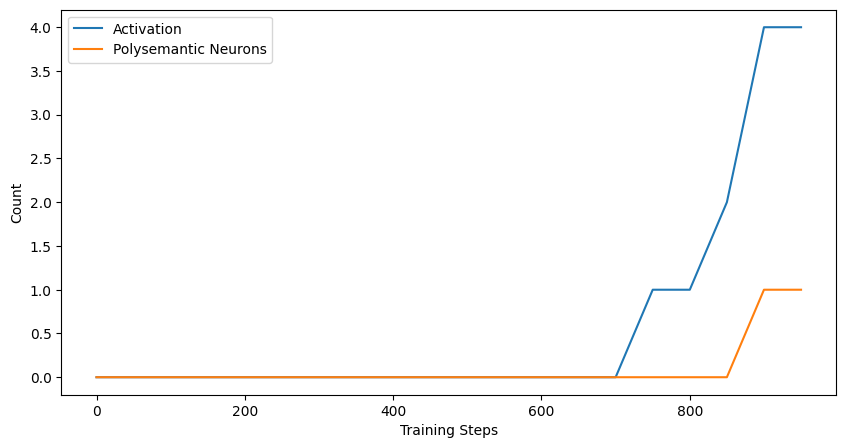

In [ ]:


# Instantiate a smaller model for quick demo
config = Config(
    n_features=32,
    n_hidden=32,
    n_instances=1,
    inputs="basis",
    tied=True,
    distri="normal",
    bias=False,
    nonlinear=True)

model = Model(
    config=config,
    device=DEVICE)

# Run the experiment with the updated function
weight_checkpoints, activation_checkpoints, polysemantic_checkpoints = optimize(model, steps=1000, checkpoint_freq=50)

# Plot the training dynamics
plt.figure(figsize=(10,5))
plt.plot(range(0, 1000, 50), activation_checkpoints, label='Activation')
plt.plot(range(0, 1000, 50), polysemantic_checkpoints, label='Polysemantic Neurons')
plt.xlabel('Training Steps')
plt.ylabel('Count')
plt.legend()
plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

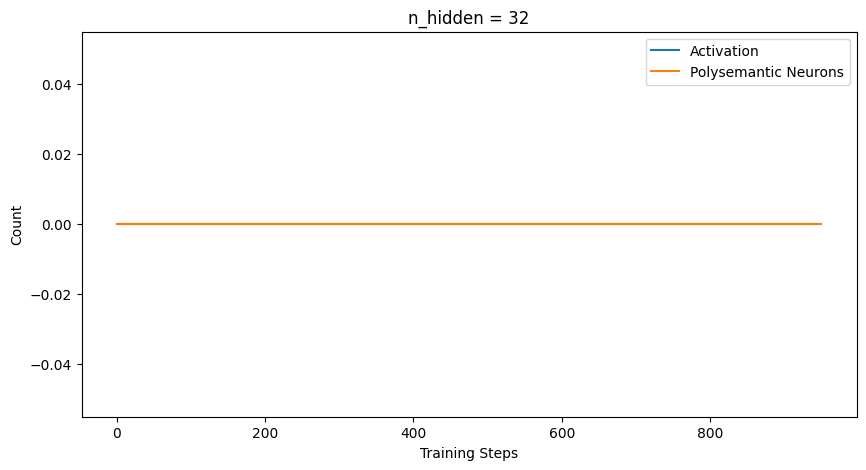

  0%|          | 0/1000 [00:00<?, ?it/s]

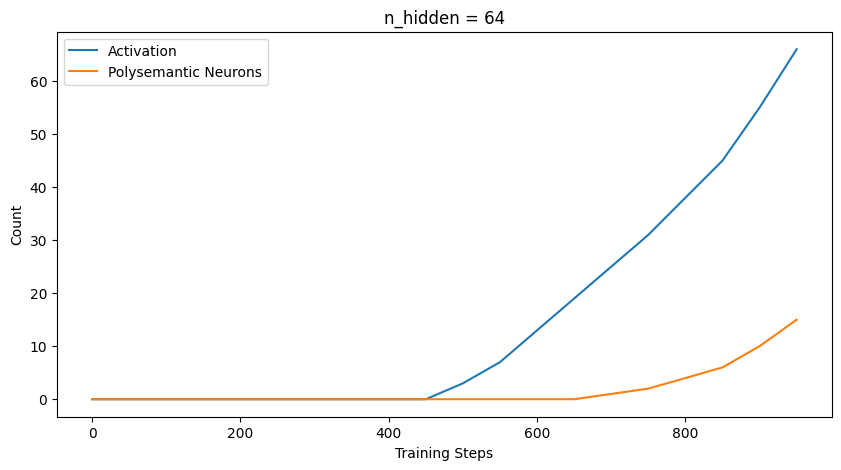

  0%|          | 0/1000 [00:00<?, ?it/s]

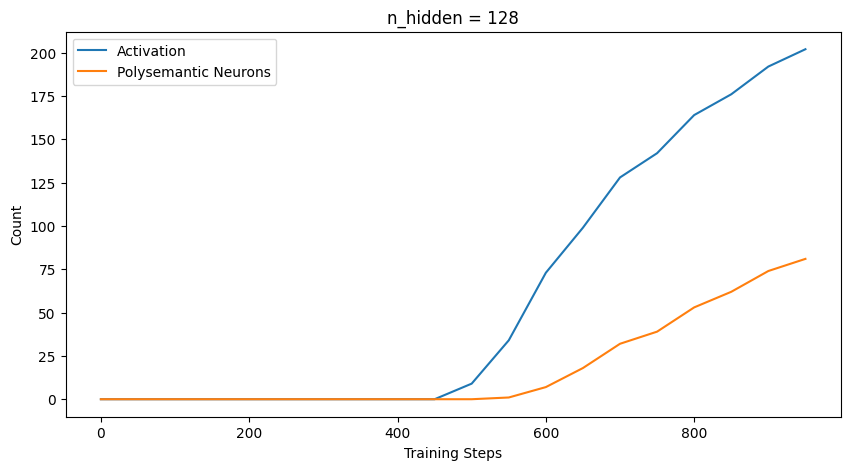

In [ ]:
hidden_sizes = [32, 64, 128]  # hidden sizes to iterate over
n_features = 256  # fixed number of features

for size in hidden_sizes:
    config = Config(
        n_features=n_features,
        n_hidden=size,
        n_instances=1,
        inputs="basis",
        tied=True,
        distri="normal",
        bias=False,
        nonlinear=True)

    model = Model(
        config=config,
        device=DEVICE)

    # Run the experiment with the updated function
    weight_checkpoints, activation_checkpoints, polysemantic_checkpoints = optimize(model, steps=1000, checkpoint_freq=50)

    # Plot the training dynamics
    plt.figure(figsize=(10,5))
    plt.plot(range(0, 1000, 50), activation_checkpoints, label='Activation')
    plt.plot(range(0, 1000, 50), polysemantic_checkpoints, label='Polysemantic Neurons')
    plt.xlabel('Training Steps')
    plt.ylabel('Count')
    plt.title(f"n_hidden = {size}")
    plt.legend()
    plt.show()


In [ ]:
configs = [Config(n_features=50, n_hidden=size, n_instances=1, inputs="basis", tied=True, distri="normal", bias=False, nonlinear=True) for size in [32, 64, 128, 256]]


In [ ]:
models = [Model(config=config, device=DEVICE) for config in configs]
for model in models:
    optimize(model, l1_factor=0.001)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
polysemantics = []
for model in models:
    weight_matrix = model.W.detach().cpu().numpy()
    weight_matrix = weight_matrix[0]
    absolute_matrix = np.abs(weight_matrix)
    activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
    count_neuron_activate = activation_mask.sum(axis=0)
    count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
    polysemantics.append(count_polysemantic)


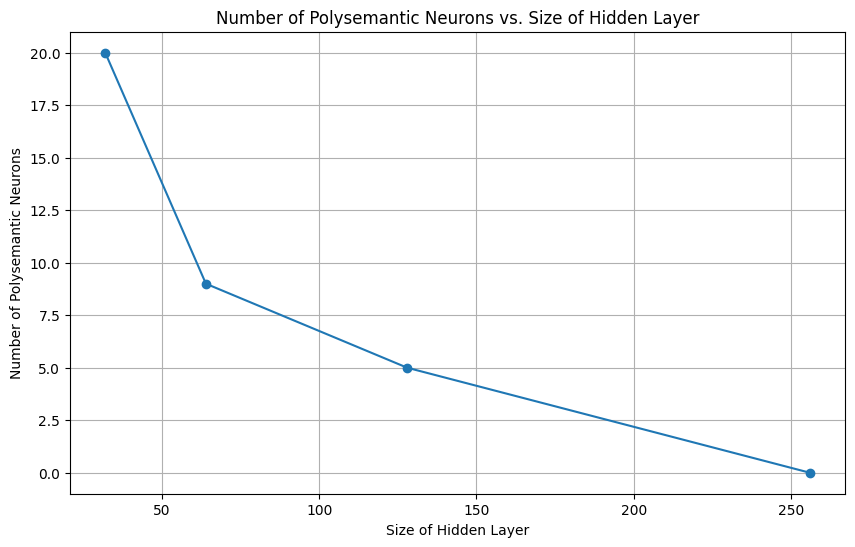

In [ ]:
import matplotlib.pyplot as plt

# Assume that `hidden_sizes` is a list of the same length as `polysemantics`,
# where `hidden_sizes[i]` is the size of the hidden layer for the model that
# corresponds to `polysemantics[i]`.

hidden_sizes = [32, 64, 128, 256]  # Replace with your actual values.

plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, polysemantics, marker='o')
plt.xlabel('Size of Hidden Layer')
plt.ylabel('Number of Polysemantic Neurons')
plt.title('Number of Polysemantic Neurons vs. Size of Hidden Layer')
plt.grid(True)
plt.show()
